# **CELLULE 1: Installation des dépendances**

In [1]:
!pip install torch torchvision torchaudio
!pip install h5py
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm
!pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# **CELLULE 2: Imports et configuration**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import os
import requests
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Configuration du device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cuda


# **CELLULE 3: Téléchargement et préparation des données ModelNet10**

In [3]:
def download_modelnet10():
    """Télécharge et extrait le dataset ModelNet10"""
    url = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
    filename = "ModelNet10.zip"

    if not os.path.exists("ModelNet10"):
        print("Téléchargement de ModelNet10...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(filename, 'wb') as file, tqdm(
            desc="Téléchargement",
            total=total_size,
            unit='B',
            unit_scale=True
        ) as bar:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
                    bar.update(len(chunk))

        print("Extraction des fichiers...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('.')

        os.remove(filename)
        print("ModelNet10 téléchargé et extrait avec succès!")
    else:
        print("ModelNet10 déjà présent.")

# Télécharger les données
download_modelnet10()

Téléchargement de ModelNet10...


Téléchargement: 100%|██████████| 473M/473M [00:06<00:00, 75.2MB/s]


Extraction des fichiers...
ModelNet10 téléchargé et extrait avec succès!


# **CELLULE 4: Classe Dataset personnalisée**

In [4]:
import glob

class ModelNet10Dataset(Dataset):
    def __init__(self, root_dir, split='train', num_points=1024):
        self.root_dir = root_dir
        self.split = split
        self.num_points = num_points

        # Classes ModelNet10
        self.classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser',
                       'monitor', 'night_stand', 'sofa', 'table', 'toilet']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Charger les fichiers
        self.files = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name, split)
            if os.path.exists(class_dir):
                files = glob.glob(os.path.join(class_dir, "*.off"))
                self.files.extend(files)
                self.labels.extend([self.class_to_idx[class_name]] * len(files))

        print(f"Dataset {split}: {len(self.files)} fichiers chargés")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Charger le fichier OFF
        points = self.load_off_file(self.files[idx])

        # Échantillonner le nombre de points requis
        if len(points) >= self.num_points:
            # Échantillonnage aléatoire
            indices = np.random.choice(len(points), self.num_points, replace=False)
            points = points[indices]
        else:
            # Duplication si pas assez de points
            indices = np.random.choice(len(points), self.num_points, replace=True)
            points = points[indices]

        # Normalisation
        points = self.normalize_points(points)

        return torch.FloatTensor(points), torch.LongTensor([self.labels[idx]])

    def load_off_file(self, filename):
        """Charge un fichier OFF et retourne les points 3D"""
        with open(filename, 'r') as file:
            lines = file.readlines()

        # Vérifier l'en-tête OFF
        if lines[0].strip() != 'OFF':
            raise ValueError(f"Fichier {filename} n'est pas au format OFF")

        # Lire le nombre de vertices et faces
        n_vertices, n_faces, _ = map(int, lines[1].split())

        # Lire les vertices
        vertices = []
        for i in range(2, 2 + n_vertices):
            vertex = list(map(float, lines[i].split()[:3]))
            vertices.append(vertex)

        return np.array(vertices)

    def normalize_points(self, points):
        """Normalise les points dans une sphère unitaire"""
        # Centrer les points
        centroid = np.mean(points, axis=0)
        points = points - centroid

        # Normaliser la taille
        m = np.max(np.sqrt(np.sum(points**2, axis=1)))
        points = points / m

        return points

Visualisation des fichiers OFF originaux...


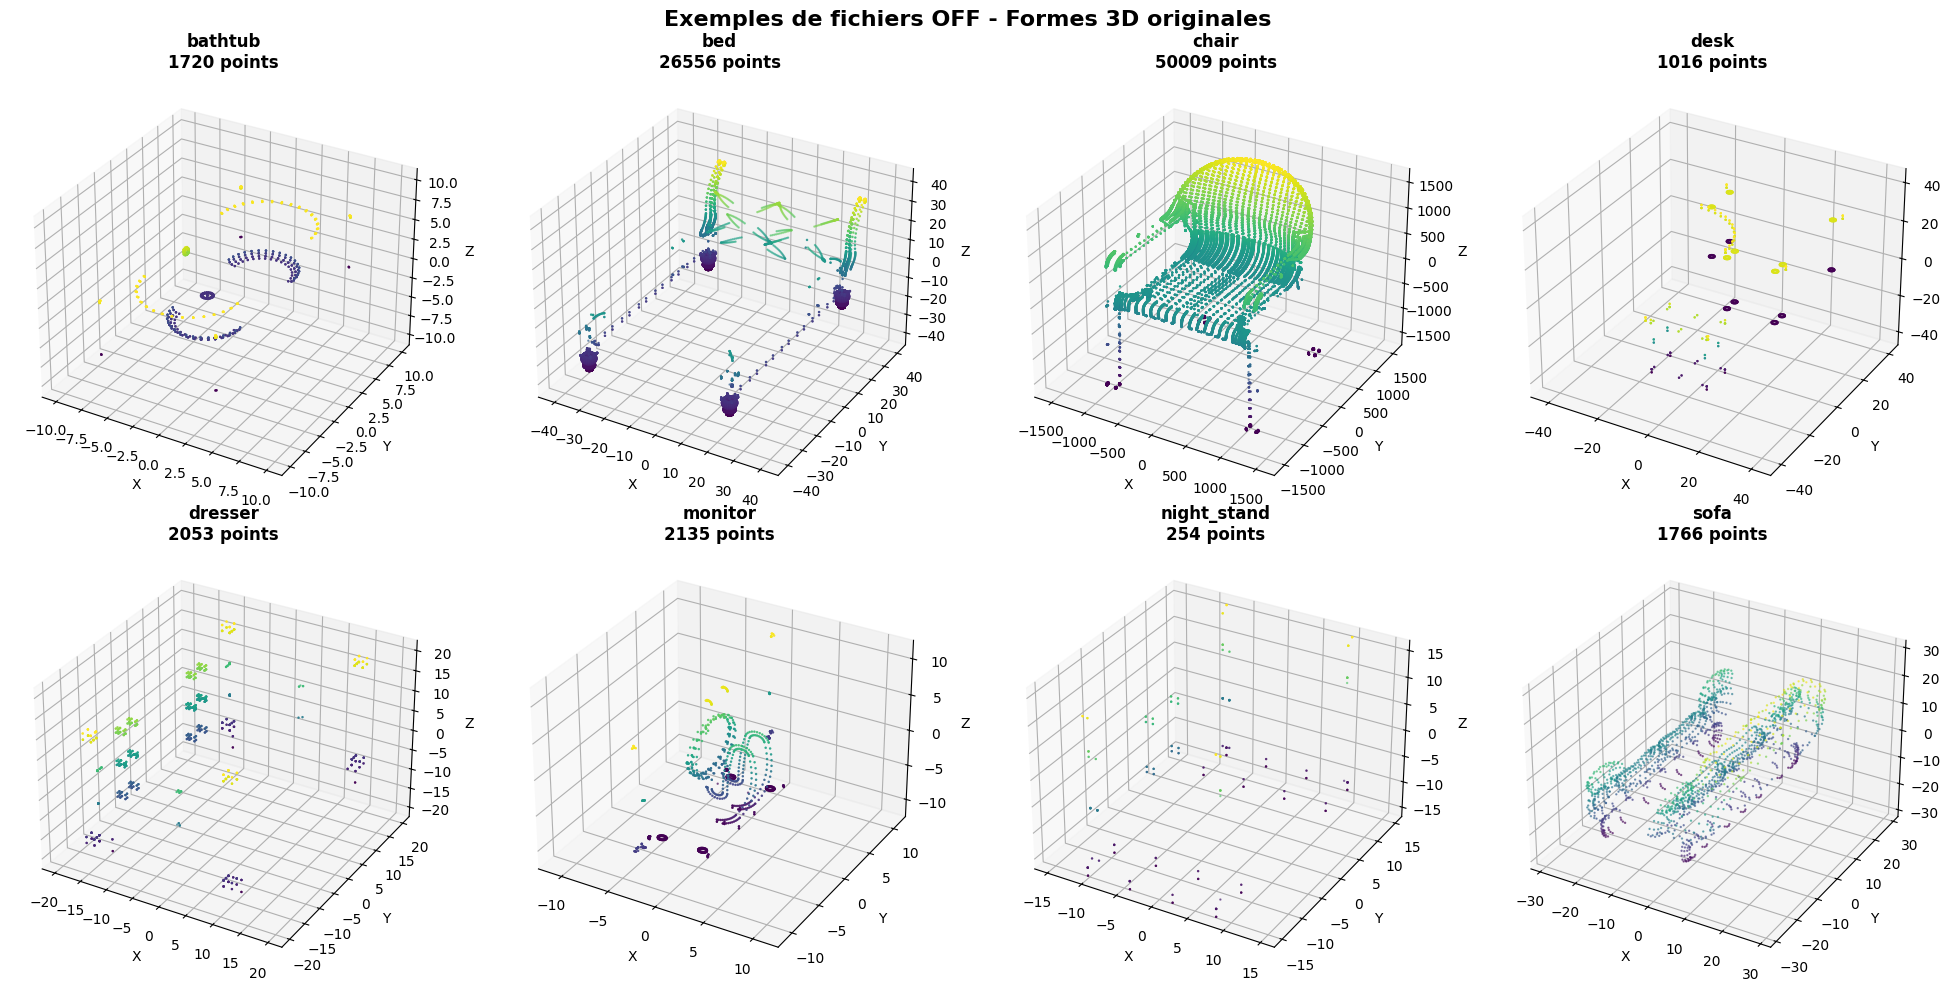

In [11]:
def visualize_off_files(dataset, num_samples=8):
    """Visualise plusieurs fichiers OFF de différentes classes"""
    fig = plt.figure(figsize=(20, 10))

    # Sélectionner des échantillons de différentes classes
    samples_per_class = max(1, num_samples // len(dataset.classes))
    samples = []

    for class_idx, class_name in enumerate(dataset.classes):
        class_indices = [i for i, label in enumerate(dataset.labels) if label == class_idx]
        selected_indices = np.random.choice(class_indices,
                                          min(samples_per_class, len(class_indices)),
                                          replace=False)
        for idx in selected_indices:
            if len(samples) < num_samples:
                samples.append((idx, class_name))

    for i, (idx, class_name) in enumerate(samples):
        # Charger les données originales (avant preprocessing)
        original_points = dataset.load_off_file(dataset.files[idx])

        # Subplot
        ax = fig.add_subplot(2, 4, i+1, projection='3d')

        # Visualiser les points
        ax.scatter(original_points[:, 0], original_points[:, 1], original_points[:, 2],
                  c=original_points[:, 2], cmap='viridis', s=0.5, alpha=0.6)

        ax.set_title(f'{class_name}\n{len(original_points)} points', fontsize=12, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Égaliser les axes
        max_range = np.array([original_points[:,0].max()-original_points[:,0].min(),
                             original_points[:,1].max()-original_points[:,1].min(),
                             original_points[:,2].max()-original_points[:,2].min()]).max() / 2.0
        mid_x = (original_points[:,0].max()+original_points[:,0].min()) * 0.5
        mid_y = (original_points[:,1].max()+original_points[:,1].min()) * 0.5
        mid_z = (original_points[:,2].max()+original_points[:,2].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.suptitle('Exemples de fichiers OFF - Formes 3D originales', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualiser les fichiers OFF
print("Visualisation des fichiers OFF originaux...")
visualize_off_files(train_dataset, num_samples=8)

Comparaison avant/après prétraitement...


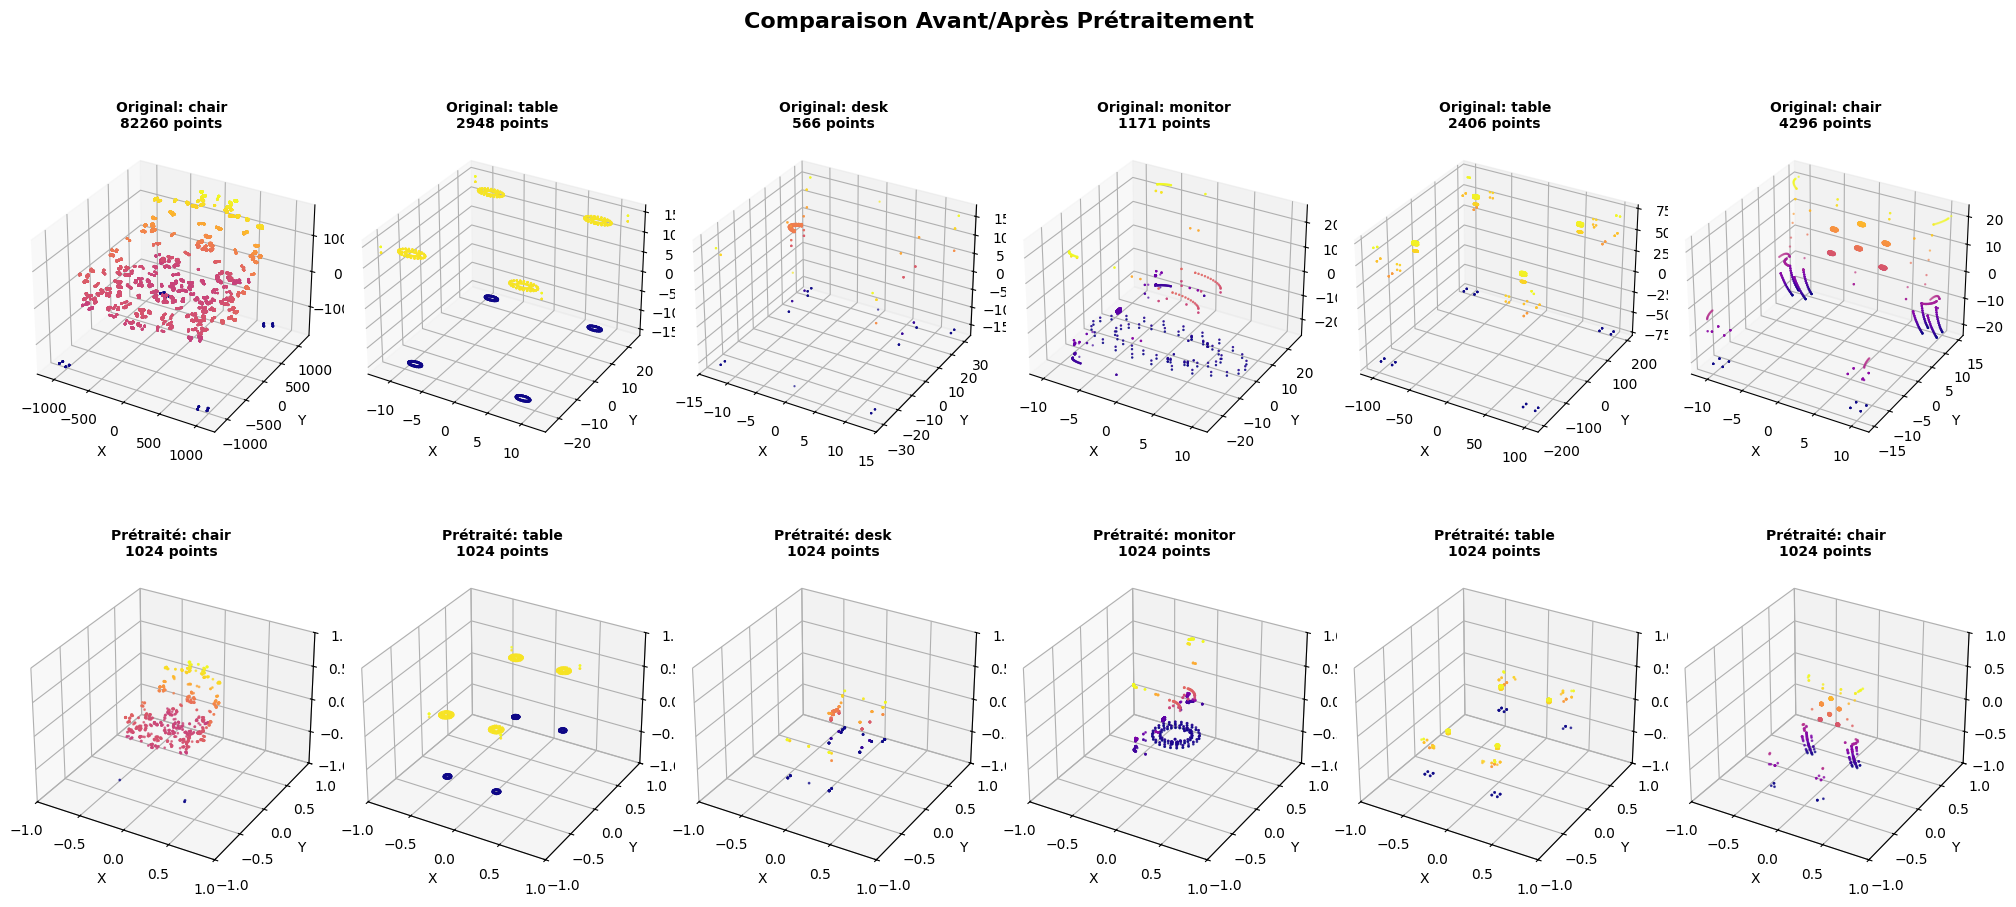

In [12]:
def compare_preprocessing(dataset, num_samples=6):
    """Compare les données avant et après prétraitement"""
    fig = plt.figure(figsize=(20, 10))

    # Sélectionner des échantillons aléatoires
    sample_indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        # Données originales
        original_points = dataset.load_off_file(dataset.files[idx])
        class_name = dataset.classes[dataset.labels[idx]]

        # Données prétraitées
        processed_points, _ = dataset[idx]
        processed_points = processed_points.numpy()

        # Subplot original
        ax1 = fig.add_subplot(2, num_samples, i+1, projection='3d')
        ax1.scatter(original_points[:, 0], original_points[:, 1], original_points[:, 2],
                   c=original_points[:, 2], cmap='plasma', s=0.5, alpha=0.6)
        ax1.set_title(f'Original: {class_name}\n{len(original_points)} points',
                     fontsize=10, fontweight='bold')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')

        # Subplot prétraité
        ax2 = fig.add_subplot(2, num_samples, i+1+num_samples, projection='3d')
        ax2.scatter(processed_points[:, 0], processed_points[:, 1], processed_points[:, 2],
                   c=processed_points[:, 2], cmap='plasma', s=1, alpha=0.7)
        ax2.set_title(f'Prétraité: {class_name}\n{len(processed_points)} points',
                     fontsize=10, fontweight='bold')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')

        # Égaliser les axes pour le prétraité
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(-1, 1)
        ax2.set_zlim(-1, 1)

    plt.suptitle('Comparaison Avant/Après Prétraitement', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Comparer avant/après prétraitement
print("Comparaison avant/après prétraitement...")
compare_preprocessing(train_dataset, num_samples=6)

Analyse de la distribution du dataset...


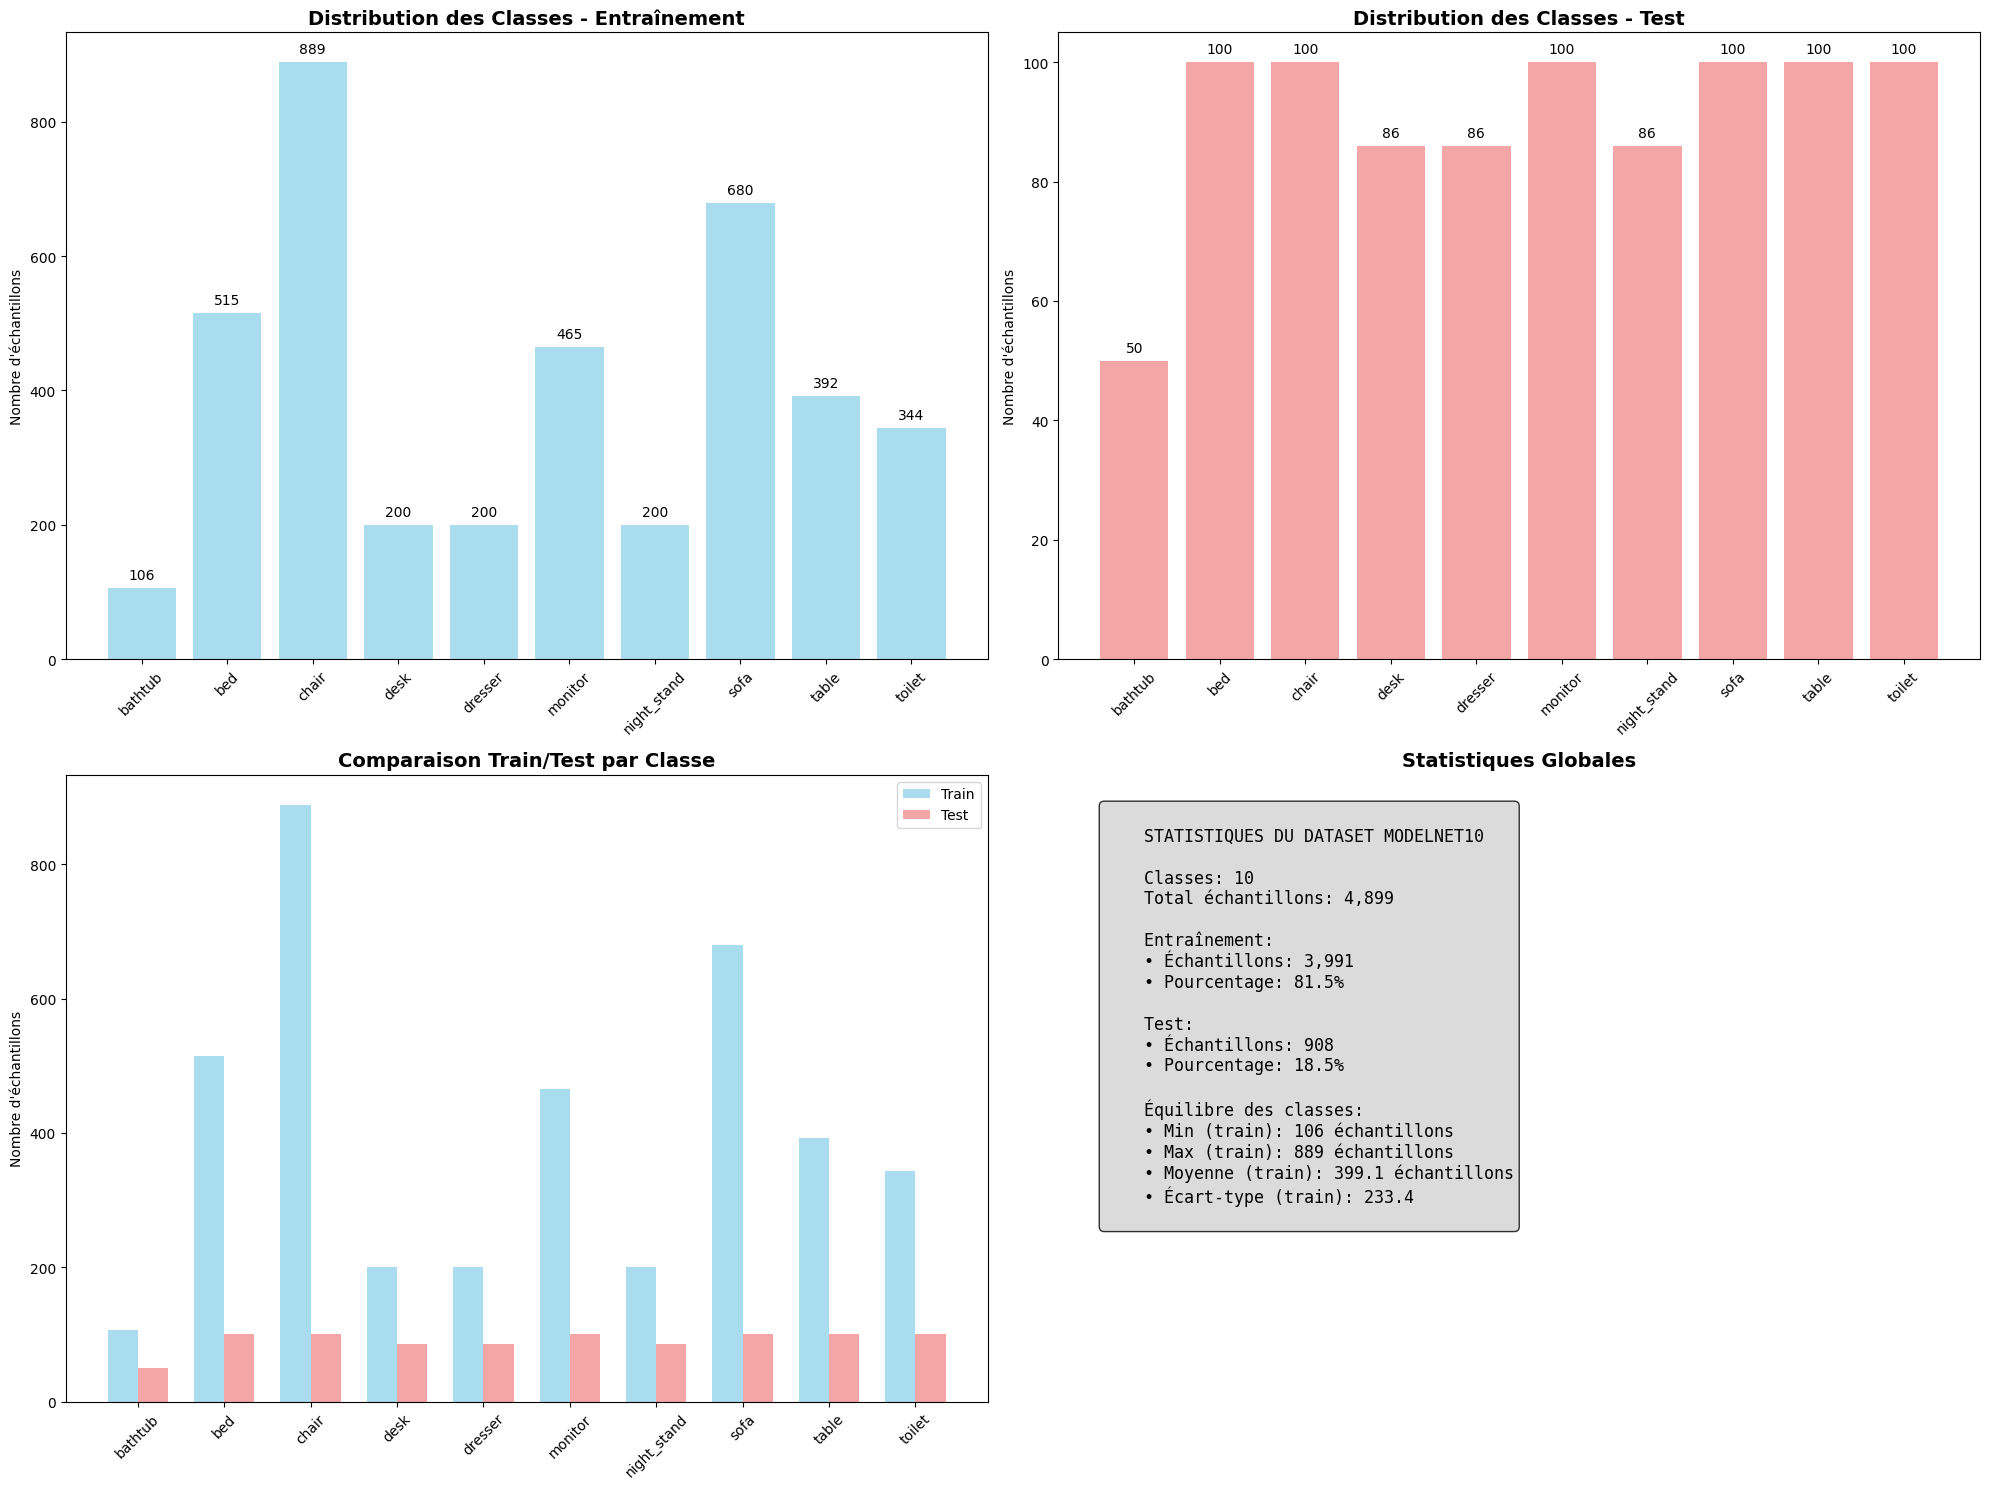


DÉTAIL PAR CLASSE:
------------------------------------------------------------
Classe       Train    Test     Total    Ratio T/T 
------------------------------------------------------------
bathtub      106      50       156      2.12      
bed          515      100      615      5.15      
chair        889      100      989      8.89      
desk         200      86       286      2.33      
dresser      200      86       286      2.33      
monitor      465      100      565      4.65      
night_stand  200      86       286      2.33      
sofa         680      100      780      6.80      
table        392      100      492      3.92      
toilet       344      100      444      3.44      
------------------------------------------------------------
TOTAL        3991     908      4899     4.40      


In [13]:
def analyze_dataset_distribution(train_dataset, test_dataset):
    """Analyse la distribution des classes dans le dataset"""

    # Compter les échantillons par classe
    train_counts = {class_name: 0 for class_name in train_dataset.classes}
    test_counts = {class_name: 0 for class_name in test_dataset.classes}

    for label in train_dataset.labels:
        class_name = train_dataset.classes[label]
        train_counts[class_name] += 1

    for label in test_dataset.labels:
        class_name = test_dataset.classes[label]
        test_counts[class_name] += 1

    # Créer les graphiques
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # 1. Distribution des classes - Train
    classes = list(train_counts.keys())
    train_values = list(train_counts.values())
    test_values = list(test_counts.values())

    axes[0, 0].bar(classes, train_values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Distribution des Classes - Entraînement', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Nombre d\'échantillons')
    axes[0, 0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(train_values):
        axes[0, 0].text(i, v + max(train_values)*0.01, str(v), ha='center', va='bottom')

    # 2. Distribution des classes - Test
    axes[0, 1].bar(classes, test_values, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Distribution des Classes - Test', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Nombre d\'échantillons')
    axes[0, 1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(test_values):
        axes[0, 1].text(i, v + max(test_values)*0.01, str(v), ha='center', va='bottom')

    # 3. Comparaison Train/Test
    x = np.arange(len(classes))
    width = 0.35

    axes[1, 0].bar(x - width/2, train_values, width, label='Train', color='skyblue', alpha=0.7)
    axes[1, 0].bar(x + width/2, test_values, width, label='Test', color='lightcoral', alpha=0.7)
    axes[1, 0].set_title('Comparaison Train/Test par Classe', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Nombre d\'échantillons')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(classes, rotation=45)
    axes[1, 0].legend()

    # 4. Statistiques globales
    total_train = sum(train_values)
    total_test = sum(test_values)
    total_samples = total_train + total_test

    stats_text = f"""
    STATISTIQUES DU DATASET MODELNET10

    Classes: {len(classes)}
    Total échantillons: {total_samples:,}

    Entraînement:
    • Échantillons: {total_train:,}
    • Pourcentage: {100*total_train/total_samples:.1f}%

    Test:
    • Échantillons: {total_test:,}
    • Pourcentage: {100*total_test/total_samples:.1f}%

    Équilibre des classes:
    • Min (train): {min(train_values)} échantillons
    • Max (train): {max(train_values)} échantillons
    • Moyenne (train): {np.mean(train_values):.1f} échantillons
    • Écart-type (train): {np.std(train_values):.1f}
    """

    axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes,
                    fontsize=12, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Statistiques Globales', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Afficher le tableau détaillé
    print("\nDÉTAIL PAR CLASSE:")
    print("-" * 60)
    print(f"{'Classe':<12} {'Train':<8} {'Test':<8} {'Total':<8} {'Ratio T/T':<10}")
    print("-" * 60)

    for class_name in classes:
        train_count = train_counts[class_name]
        test_count = test_counts[class_name]
        total_count = train_count + test_count
        ratio = train_count / test_count if test_count > 0 else float('inf')
        print(f"{class_name:<12} {train_count:<8} {test_count:<8} {total_count:<8} {ratio:<10.2f}")

    print("-" * 60)
    print(f"{'TOTAL':<12} {total_train:<8} {total_test:<8} {total_samples:<8} {total_train/total_test:<10.2f}")

# Analyser la distribution
print("Analyse de la distribution du dataset...")
analyze_dataset_distribution(train_dataset, test_dataset)

Analyse des nuages de points...


Analyse en cours: 100%|██████████| 500/500 [00:16<00:00, 30.11it/s]
<ipython-input-14-5dde65088ea9>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(class_data, labels=dataset.classes, patch_artist=True)


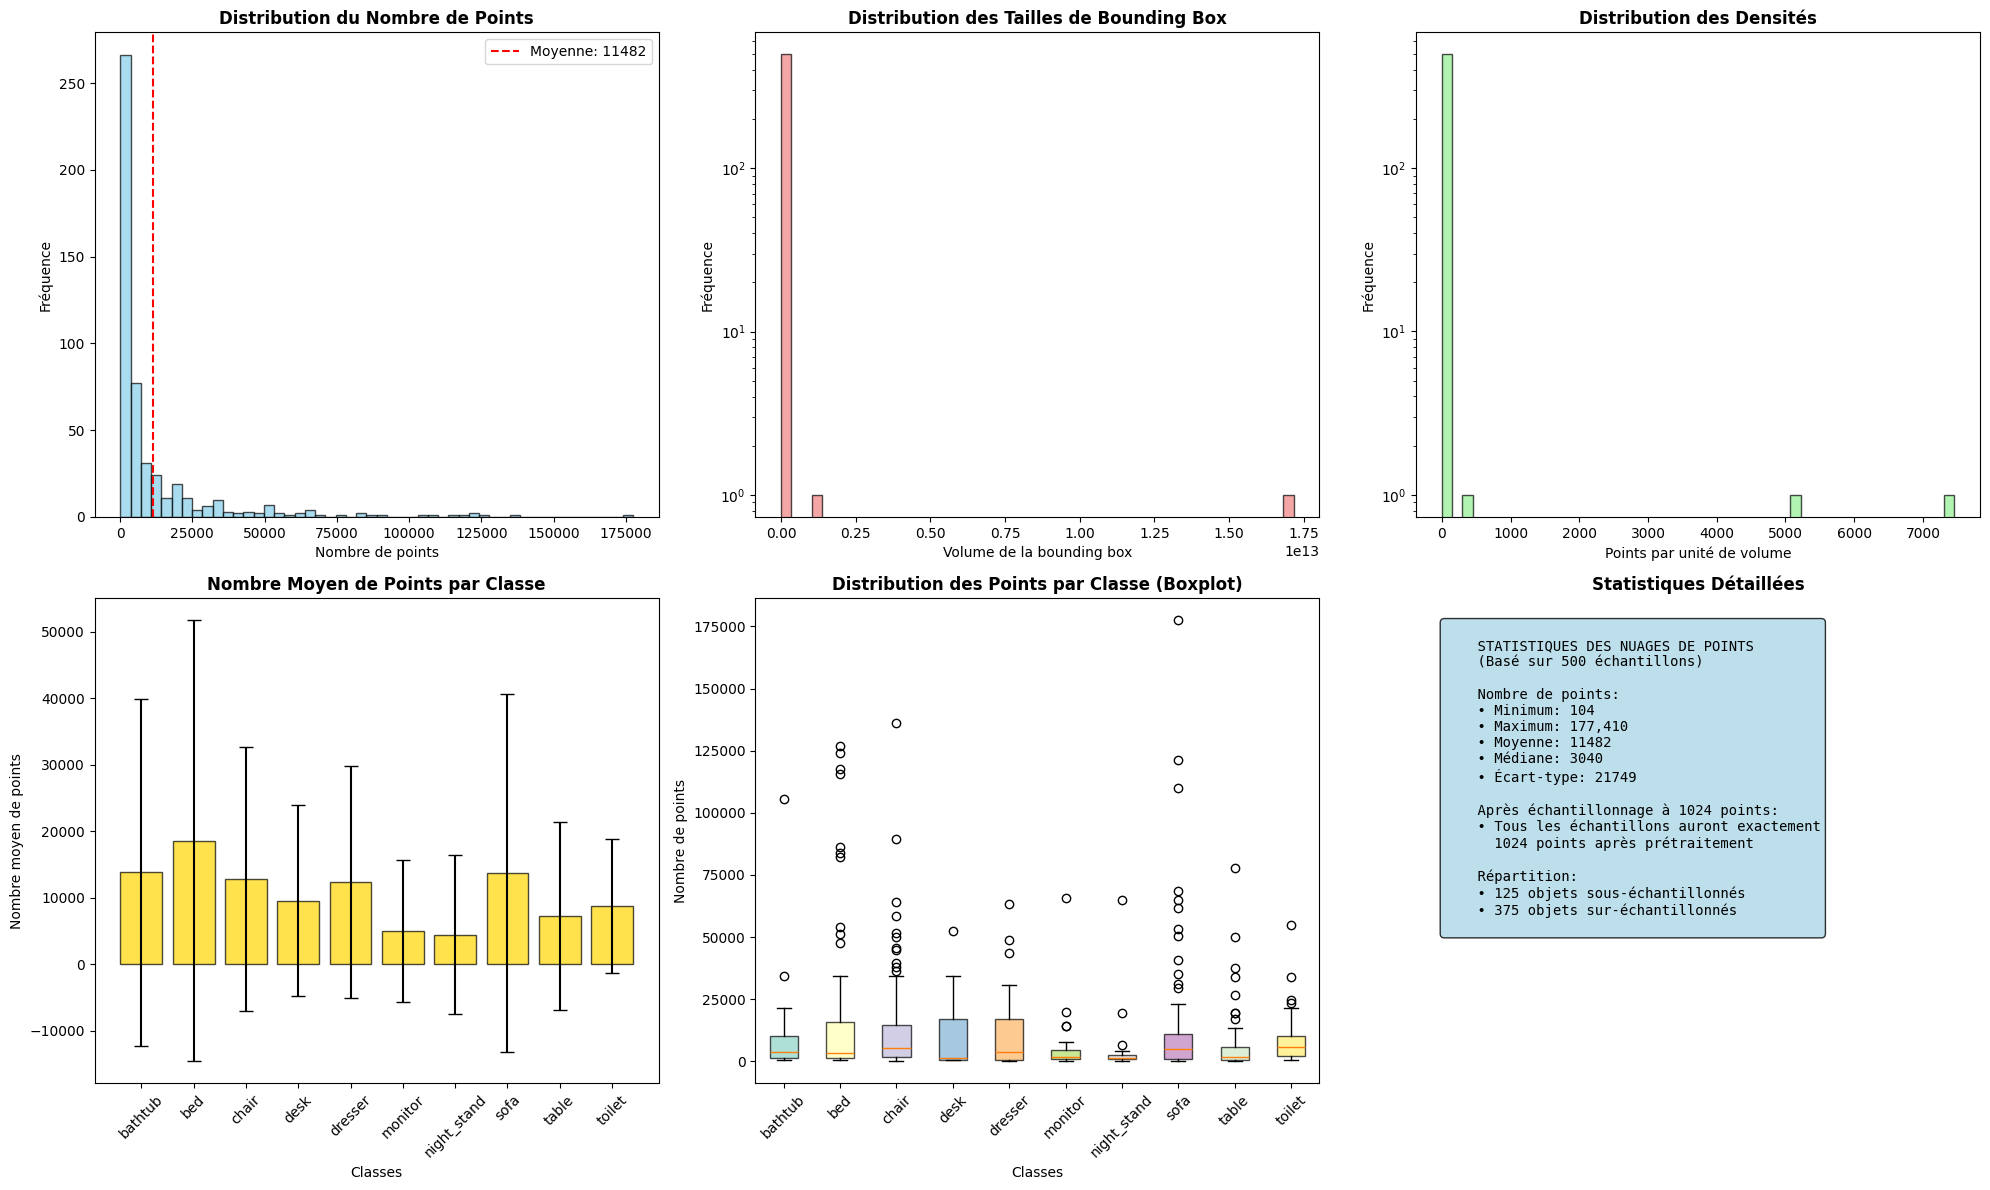

In [14]:
def analyze_point_clouds(dataset, num_samples=1000):
    """Analyse les caractéristiques des nuages de points"""

    print("Analyse des nuages de points...")

    # Échantillonner des indices aléatoires
    sample_indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

    # Collecter les statistiques
    point_counts = []
    bounding_box_sizes = []
    densities = []

    for idx in tqdm(sample_indices, desc="Analyse en cours"):
        points = dataset.load_off_file(dataset.files[idx])

        # Nombre de points
        point_counts.append(len(points))

        # Taille de la bounding box
        min_coords = np.min(points, axis=0)
        max_coords = np.max(points, axis=0)
        bbox_size = np.prod(max_coords - min_coords)
        bounding_box_sizes.append(bbox_size)

        # Densité approximative
        if bbox_size > 0:
            density = len(points) / bbox_size
            densities.append(density)

    # Créer les visualisations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Distribution du nombre de points
    axes[0, 0].hist(point_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution du Nombre de Points', fontweight='bold')
    axes[0, 0].set_xlabel('Nombre de points')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].axvline(np.mean(point_counts), color='red', linestyle='--',
                       label=f'Moyenne: {np.mean(point_counts):.0f}')
    axes[0, 0].legend()

    # 2. Distribution des tailles de bounding box
    axes[0, 1].hist(bounding_box_sizes, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Distribution des Tailles de Bounding Box', fontweight='bold')
    axes[0, 1].set_xlabel('Volume de la bounding box')
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].set_yscale('log')

    # 3. Distribution des densités
    if densities:
        axes[0, 2].hist(densities, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0, 2].set_title('Distribution des Densités', fontweight='bold')
        axes[0, 2].set_xlabel('Points par unité de volume')
        axes[0, 2].set_ylabel('Fréquence')
        axes[0, 2].set_yscale('log')

    # 4. Nombre de points par classe
    class_point_counts = {class_name: [] for class_name in dataset.classes}

    for idx in sample_indices:
        points = dataset.load_off_file(dataset.files[idx])
        class_name = dataset.classes[dataset.labels[idx]]
        class_point_counts[class_name].append(len(points))

    class_means = [np.mean(counts) if counts else 0 for counts in class_point_counts.values()]
    class_stds = [np.std(counts) if counts else 0 for counts in class_point_counts.values()]

    x_pos = np.arange(len(dataset.classes))
    axes[1, 0].bar(x_pos, class_means, yerr=class_stds, alpha=0.7,
                   color='gold', edgecolor='black', capsize=5)
    axes[1, 0].set_title('Nombre Moyen de Points par Classe', fontweight='bold')
    axes[1, 0].set_xlabel('Classes')
    axes[1, 0].set_ylabel('Nombre moyen de points')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(dataset.classes, rotation=45)

    # 5. Boxplot du nombre de points par classe
    class_data = [class_point_counts[class_name] for class_name in dataset.classes]
    box_plot = axes[1, 1].boxplot(class_data, labels=dataset.classes, patch_artist=True)

    # Colorer les boîtes
    colors = plt.cm.Set3(np.linspace(0, 1, len(dataset.classes)))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[1, 1].set_title('Distribution des Points par Classe (Boxplot)', fontweight='bold')
    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('Nombre de points')
    axes[1, 1].tick_params(axis='x', rotation=45)

    # 6. Statistiques textuelles
    stats_text = f"""
    STATISTIQUES DES NUAGES DE POINTS
    (Basé sur {len(sample_indices)} échantillons)

    Nombre de points:
    • Minimum: {min(point_counts):,}
    • Maximum: {max(point_counts):,}
    • Moyenne: {np.mean(point_counts):.0f}
    • Médiane: {np.median(point_counts):.0f}
    • Écart-type: {np.std(point_counts):.0f}

    Après échantillonnage à {NUM_POINTS} points:
    • Tous les échantillons auront exactement
      {NUM_POINTS} points après prétraitement

    Répartition:
    • {np.sum(np.array(point_counts) < NUM_POINTS)} objets sous-échantillonnés
    • {np.sum(np.array(point_counts) >= NUM_POINTS)} objets sur-échantillonnés
    """

    axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes,
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Statistiques Détaillées', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Analyser les nuages de points
analyze_point_clouds(train_dataset, num_samples=500)

***Visualisation interactive 3D***

Visualisation 3D multi-angles pour la classe 'chair':


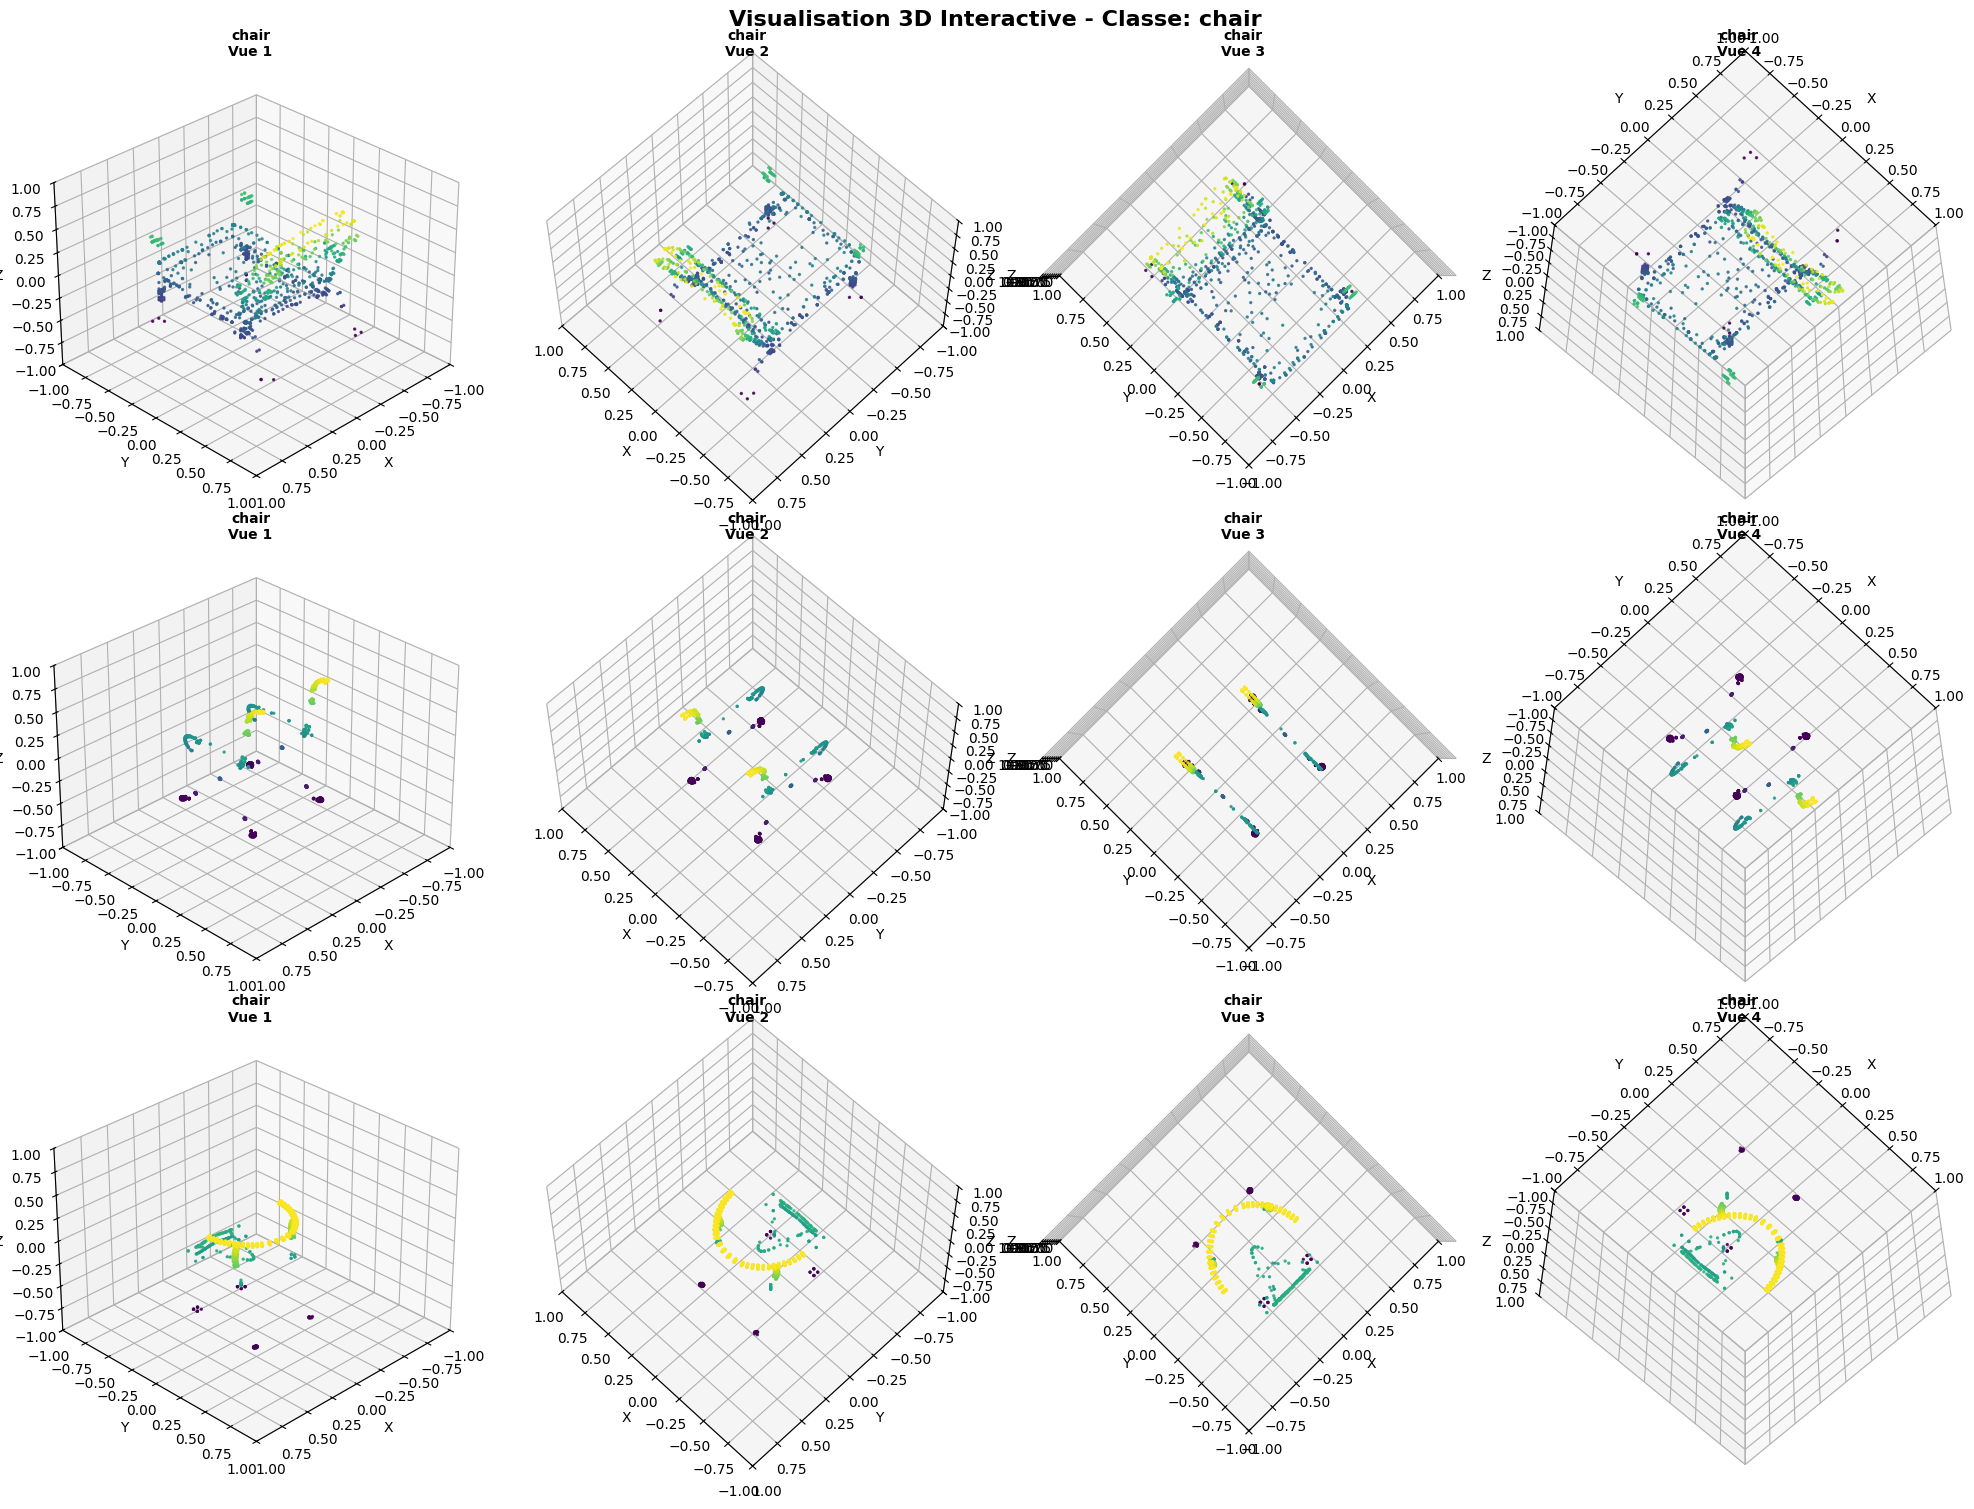


Visualisation 3D multi-angles pour différentes classes:


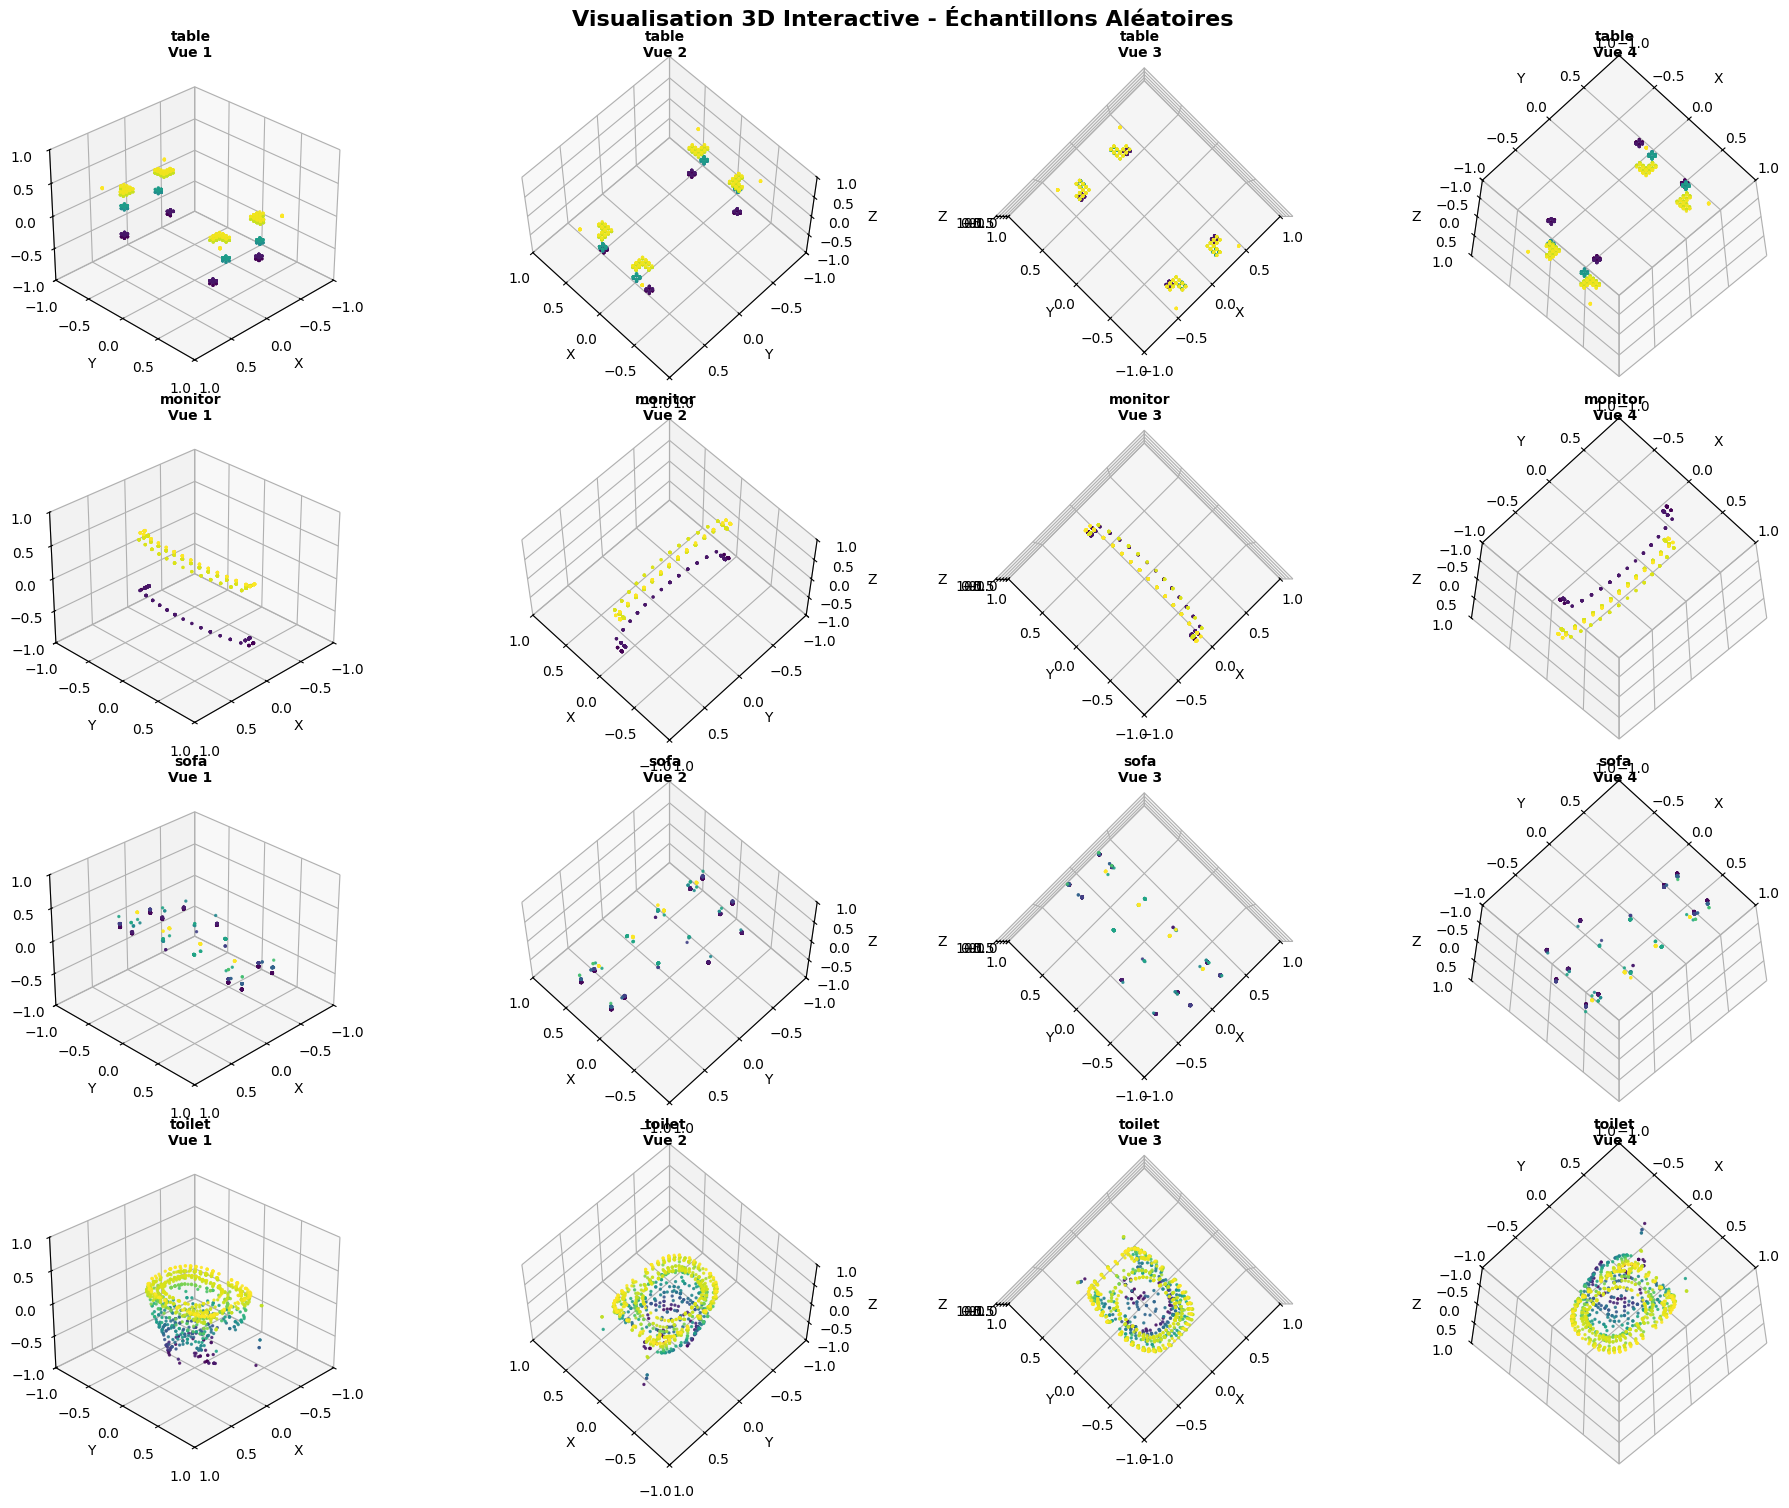


TOUTES LES VISUALISATIONS TERMINÉES!
Résumé des visualisations créées:
1. Architecture DGCNN détaillée
2. Fichiers OFF originaux (8 exemples)
3. Comparaison avant/après prétraitement (6 exemples)
4. Distribution complète du dataset
5. Analyse statistique des nuages de points
6. Visualisation 3D multi-angles


In [15]:
def create_interactive_3d_visualization(dataset, class_name=None, num_samples=4):
    """Crée une visualisation 3D interactive avec différents angles"""

    if class_name:
        # Filtrer par classe
        class_idx = dataset.classes.index(class_name)
        indices = [i for i, label in enumerate(dataset.labels) if label == class_idx]
        sample_indices = np.random.choice(indices, min(num_samples, len(indices)), replace=False)
        title = f'Visualisation 3D Interactive - Classe: {class_name}'
    else:
        # Échantillons aléatoires
        sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
        title = 'Visualisation 3D Interactive - Échantillons Aléatoires'

    fig = plt.figure(figsize=(20, 15))

    for i, idx in enumerate(sample_indices):
        # Charger les données
        points = dataset.load_off_file(dataset.files[idx])
        processed_points, _ = dataset[idx]
        processed_points = processed_points.numpy()
        class_name_sample = dataset.classes[dataset.labels[idx]]

        # 4 vues différentes pour chaque objet
        angles = [(30, 45), (60, 135), (90, 225), (120, 315)]

        for j, (elev, azim) in enumerate(angles):
            ax = fig.add_subplot(num_samples, 4, i*4 + j + 1, projection='3d')

            # Utiliser les points prétraités pour une meilleure visualisation
            ax.scatter(processed_points[:, 0], processed_points[:, 1], processed_points[:, 2],
                      c=processed_points[:, 2], cmap='viridis', s=2, alpha=0.8)

            ax.set_title(f'{class_name_sample}\nVue {j+1}', fontsize=10, fontweight='bold')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

            # Définir l'angle de vue
            ax.view_init(elev=elev, azim=azim)

            # Égaliser les axes
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            ax.set_zlim(-1, 1)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualisation interactive pour une classe spécifique
print("Visualisation 3D multi-angles pour la classe 'chair':")
create_interactive_3d_visualization(train_dataset, class_name='chair', num_samples=3)

print("\nVisualisation 3D multi-angles pour différentes classes:")
create_interactive_3d_visualization(train_dataset, num_samples=4)

print("\n" + "="*80)
print("TOUTES LES VISUALISATIONS TERMINÉES!")
print("="*80)
print("Résumé des visualisations créées:")
print("1. Architecture DGCNN détaillée")
print("2. Fichiers OFF originaux (8 exemples)")
print("3. Comparaison avant/après prétraitement (6 exemples)")
print("4. Distribution complète du dataset")
print("5. Analyse statistique des nuages de points")
print("6. Visualisation 3D multi-angles")

***Analyse des EdgeConv et features***

Visualisation des concepts EdgeConv et DGCNN...


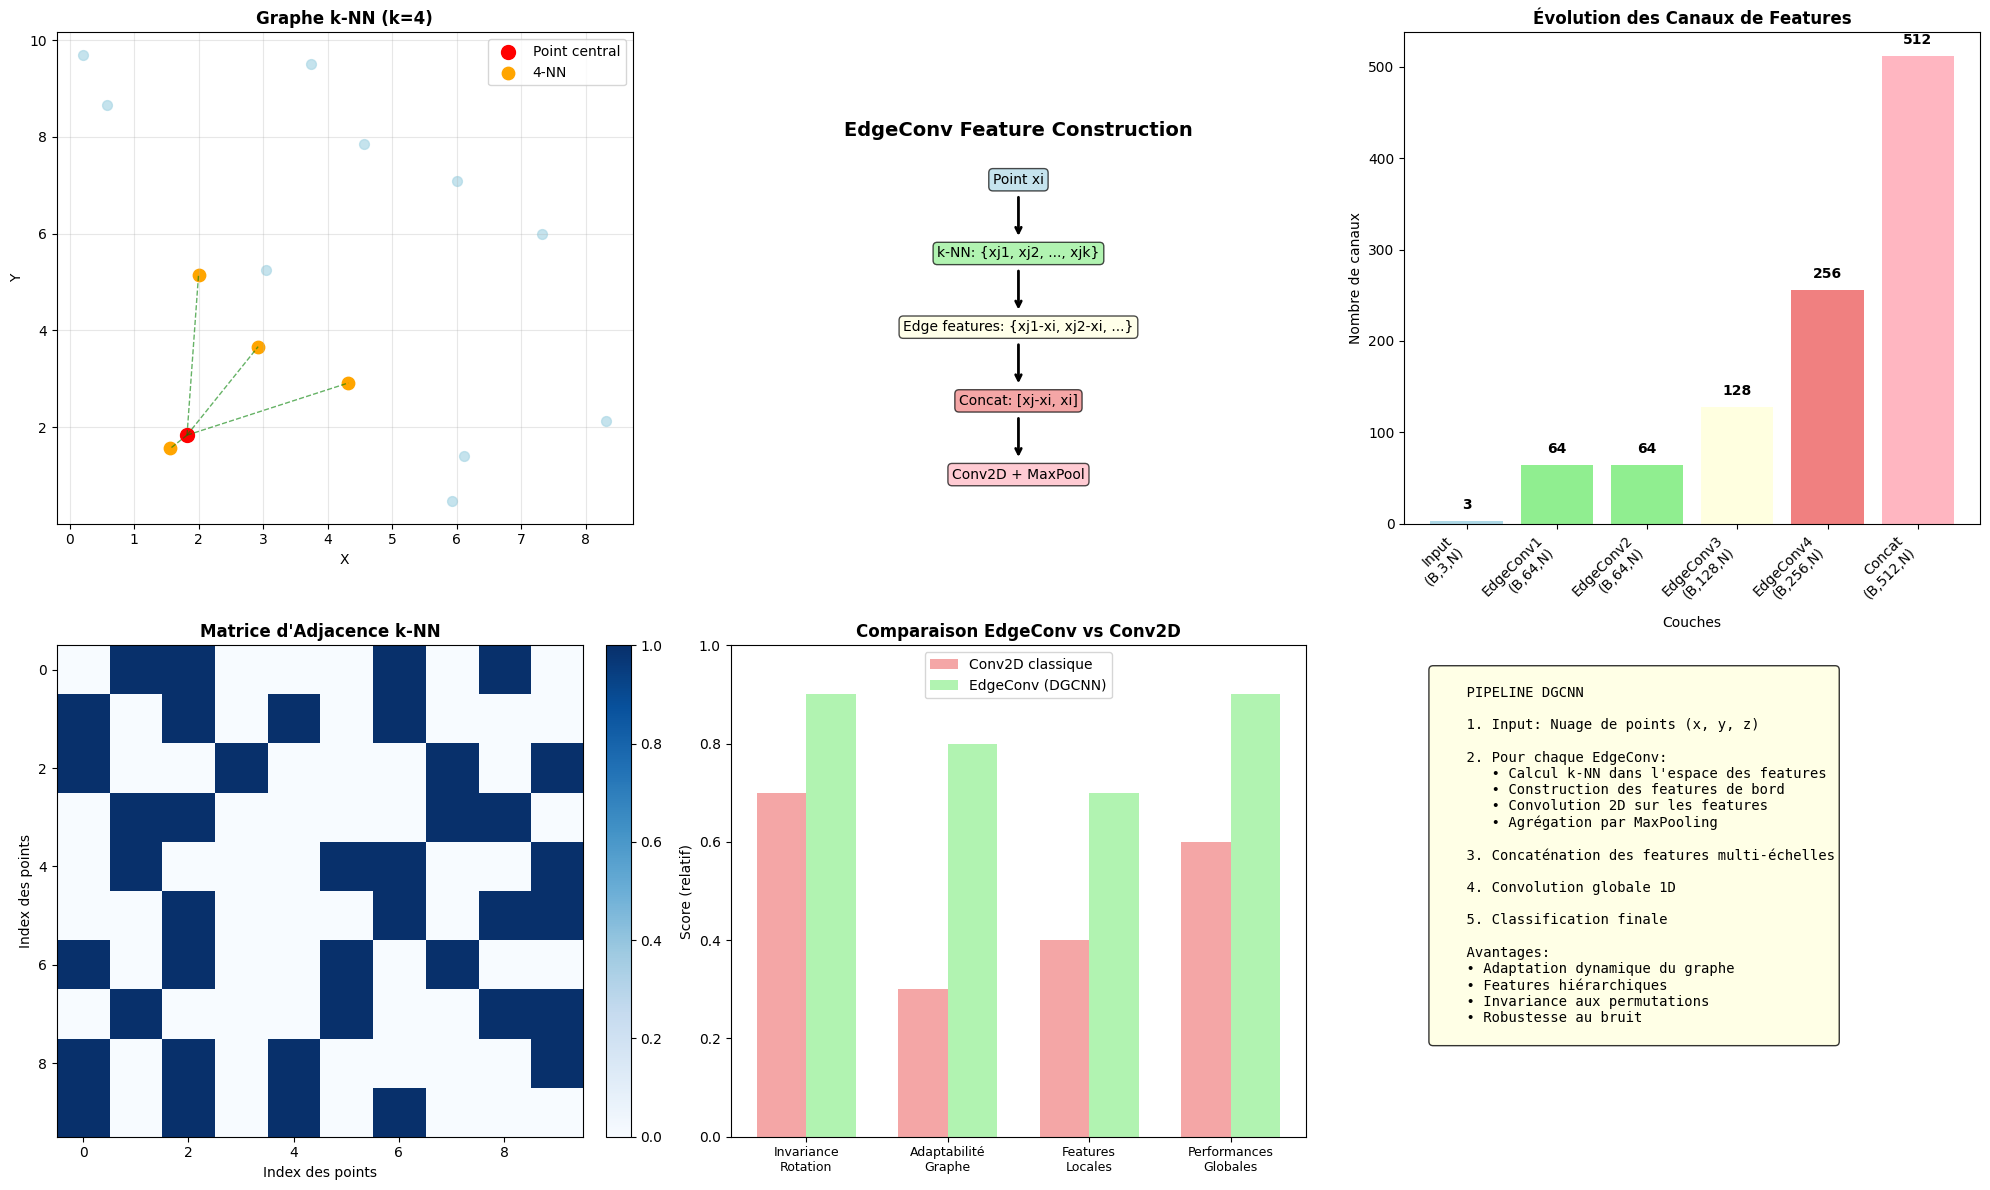

In [16]:
def visualize_edge_conv_concept():
    """Visualise le concept des EdgeConv et la construction du graphe"""

    fig = plt.figure(figsize=(20, 12))

    # 1. Concept de graphe k-NN
    ax1 = plt.subplot(2, 3, 1)

    # Générer des points 2D pour la démonstration
    np.random.seed(42)
    points = np.random.rand(15, 2) * 10

    # Calculer les k plus proches voisins pour un point central
    center_idx = 7
    center_point = points[center_idx]

    # Calculer les distances
    distances = np.sqrt(np.sum((points - center_point)**2, axis=1))
    k = 4
    nearest_indices = np.argsort(distances)[1:k+1]  # Exclure le point lui-même

    # Dessiner tous les points
    ax1.scatter(points[:, 0], points[:, 1], c='lightblue', s=50, alpha=0.7)

    # Mettre en évidence le point central
    ax1.scatter(center_point[0], center_point[1], c='red', s=100, label='Point central')

    # Mettre en évidence les k-NN
    ax1.scatter(points[nearest_indices, 0], points[nearest_indices, 1],
               c='orange', s=80, label=f'{k}-NN')

    # Dessiner les connexions
    for idx in nearest_indices:
        ax1.plot([center_point[0], points[idx, 0]],
                [center_point[1], points[idx, 1]],
                'g--', alpha=0.6, linewidth=1)

    ax1.set_title('Graphe k-NN (k=4)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    # 2. Construction des features de bord
    ax2 = plt.subplot(2, 3, 2)

    # Diagramme conceptuel des features de bord
    ax2.text(0.5, 0.8, 'EdgeConv Feature Construction',
            ha='center', va='center', fontsize=14, fontweight='bold',
            transform=ax2.transAxes)

    # Dessiner les étapes
    steps = [
        'Point xi',
        'k-NN: {xj1, xj2, ..., xjk}',
        'Edge features: {xj1-xi, xj2-xi, ...}',
        'Concat: [xj-xi, xi]',
        'Conv2D + MaxPool'
    ]

    y_positions = np.linspace(0.7, 0.1, len(steps))
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink']

    for i, (step, y_pos, color) in enumerate(zip(steps, y_positions, colors)):
        bbox = dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7)
        ax2.text(0.5, y_pos, step, ha='center', va='center',
                transform=ax2.transAxes, bbox=bbox, fontsize=10)

        if i < len(steps) - 1:
            ax2.annotate('', xy=(0.5, y_positions[i+1] + 0.03),
                        xytext=(0.5, y_pos - 0.03),
                        arrowprops=dict(arrowstyle='->', lw=2, color='black'),
                        transform=ax2.transAxes)

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # 3. Évolution des features à travers les couches
    ax3 = plt.subplot(2, 3, 3)

    layers = ['Input\n(B,3,N)', 'EdgeConv1\n(B,64,N)', 'EdgeConv2\n(B,64,N)',
              'EdgeConv3\n(B,128,N)', 'EdgeConv4\n(B,256,N)', 'Concat\n(B,512,N)']
    channels = [3, 64, 64, 128, 256, 512]

    x_pos = np.arange(len(layers))
    bars = ax3.bar(x_pos, channels, color=['lightblue', 'lightgreen', 'lightgreen',
                                          'lightyellow', 'lightcoral', 'lightpink'])

    ax3.set_title('Évolution des Canaux de Features', fontweight='bold')
    ax3.set_xlabel('Couches')
    ax3.set_ylabel('Nombre de canaux')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(layers, rotation=45, ha='right')

    # Ajouter les valeurs sur les barres
    for bar, channel in zip(bars, channels):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{channel}', ha='center', va='bottom', fontweight='bold')

    # 4. Matrice d'adjacence conceptuelle
    ax4 = plt.subplot(2, 3, 4)

    # Créer une matrice d'adjacence factice pour k=4
    n_points = 10
    adj_matrix = np.zeros((n_points, n_points))

    # Remplir avec des connexions k-NN simulées
    np.random.seed(42)
    for i in range(n_points):
        # Chaque point se connecte à k autres points
        connections = np.random.choice([j for j in range(n_points) if j != i],
                                     size=min(4, n_points-1), replace=False)
        adj_matrix[i, connections] = 1

    im = ax4.imshow(adj_matrix, cmap='Blues', aspect='auto')
    ax4.set_title('Matrice d\'Adjacence k-NN', fontweight='bold')
    ax4.set_xlabel('Index des points')
    ax4.set_ylabel('Index des points')

    # Ajouter une colorbar
    plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

    # 5. Comparaison avec les convolutions classiques
    ax5 = plt.subplot(2, 3, 5)

    comparison_data = {
        'Conv2D classique': [0.7, 0.3, 0.4, 0.6],
        'EdgeConv (DGCNN)': [0.9, 0.8, 0.7, 0.9]
    }

    metrics = ['Invariance\nRotation', 'Adaptabilité\nGraphe', 'Features\nLocales', 'Performances\nGlobales']
    x = np.arange(len(metrics))
    width = 0.35

    ax5.bar(x - width/2, comparison_data['Conv2D classique'], width,
           label='Conv2D classique', color='lightcoral', alpha=0.7)
    ax5.bar(x + width/2, comparison_data['EdgeConv (DGCNN)'], width,
           label='EdgeConv (DGCNN)', color='lightgreen', alpha=0.7)

    ax5.set_title('Comparaison EdgeConv vs Conv2D', fontweight='bold')
    ax5.set_ylabel('Score (relatif)')
    ax5.set_xticks(x)
    ax5.set_xticklabels(metrics, fontsize=9)
    ax5.legend()
    ax5.set_ylim(0, 1)

    # 6. Pipeline de traitement DGCNN
    ax6 = plt.subplot(2, 3, 6)

    pipeline_text = """
    PIPELINE DGCNN

    1. Input: Nuage de points (x, y, z)

    2. Pour chaque EdgeConv:
       • Calcul k-NN dans l'espace des features
       • Construction des features de bord
       • Convolution 2D sur les features
       • Agrégation par MaxPooling

    3. Concaténation des features multi-échelles

    4. Convolution globale 1D

    5. Classification finale

    Avantages:
    • Adaptation dynamique du graphe
    • Features hiérarchiques
    • Invariance aux permutations
    • Robustesse au bruit
    """

    ax6.text(0.05, 0.95, pipeline_text, transform=ax6.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    ax6.set_xlim(0, 1)
    ax6.set_ylim(0, 1)
    ax6.axis('off')

    plt.tight_layout()
    plt.show()

# Visualiser les concepts EdgeConv
print("Visualisation des concepts EdgeConv et DGCNN...")
visualize_edge_conv_concept()


# **CELLULE 5: Architecture DGCNN**

In [5]:
def knn(x, k):
    """Trouve les k plus proches voisins"""
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)

    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx

def get_graph_feature(x, k=20, idx=None):
    """Construit les features de graphe"""
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)

    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points
    idx = idx + idx_base
    idx = idx.view(-1)

    _, num_dims, _ = x.size()
    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)

    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()

    return feature

class DGCNN(nn.Module):
    def __init__(self, num_classes=10, k=20, dropout=0.5):
        super(DGCNN, self).__init__()
        self.k = k

        # EdgeConv layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Global feature extraction
        self.conv5 = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=dropout),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # EdgeConv 1
        x1 = get_graph_feature(x, k=self.k)
        x1 = self.conv1(x1)
        x1 = x1.max(dim=-1, keepdim=False)[0]

        # EdgeConv 2
        x2 = get_graph_feature(x1, k=self.k)
        x2 = self.conv2(x2)
        x2 = x2.max(dim=-1, keepdim=False)[0]

        # EdgeConv 3
        x3 = get_graph_feature(x2, k=self.k)
        x3 = self.conv3(x3)
        x3 = x3.max(dim=-1, keepdim=False)[0]

        # EdgeConv 4
        x4 = get_graph_feature(x3, k=self.k)
        x4 = self.conv4(x4)
        x4 = x4.max(dim=-1, keepdim=False)[0]

        # Concaténation des features
        x = torch.cat((x1, x2, x3, x4), dim=1)

        # Global feature
        x = self.conv5(x)
        x = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)

        # Classification
        x = self.classifier(x)

        return x

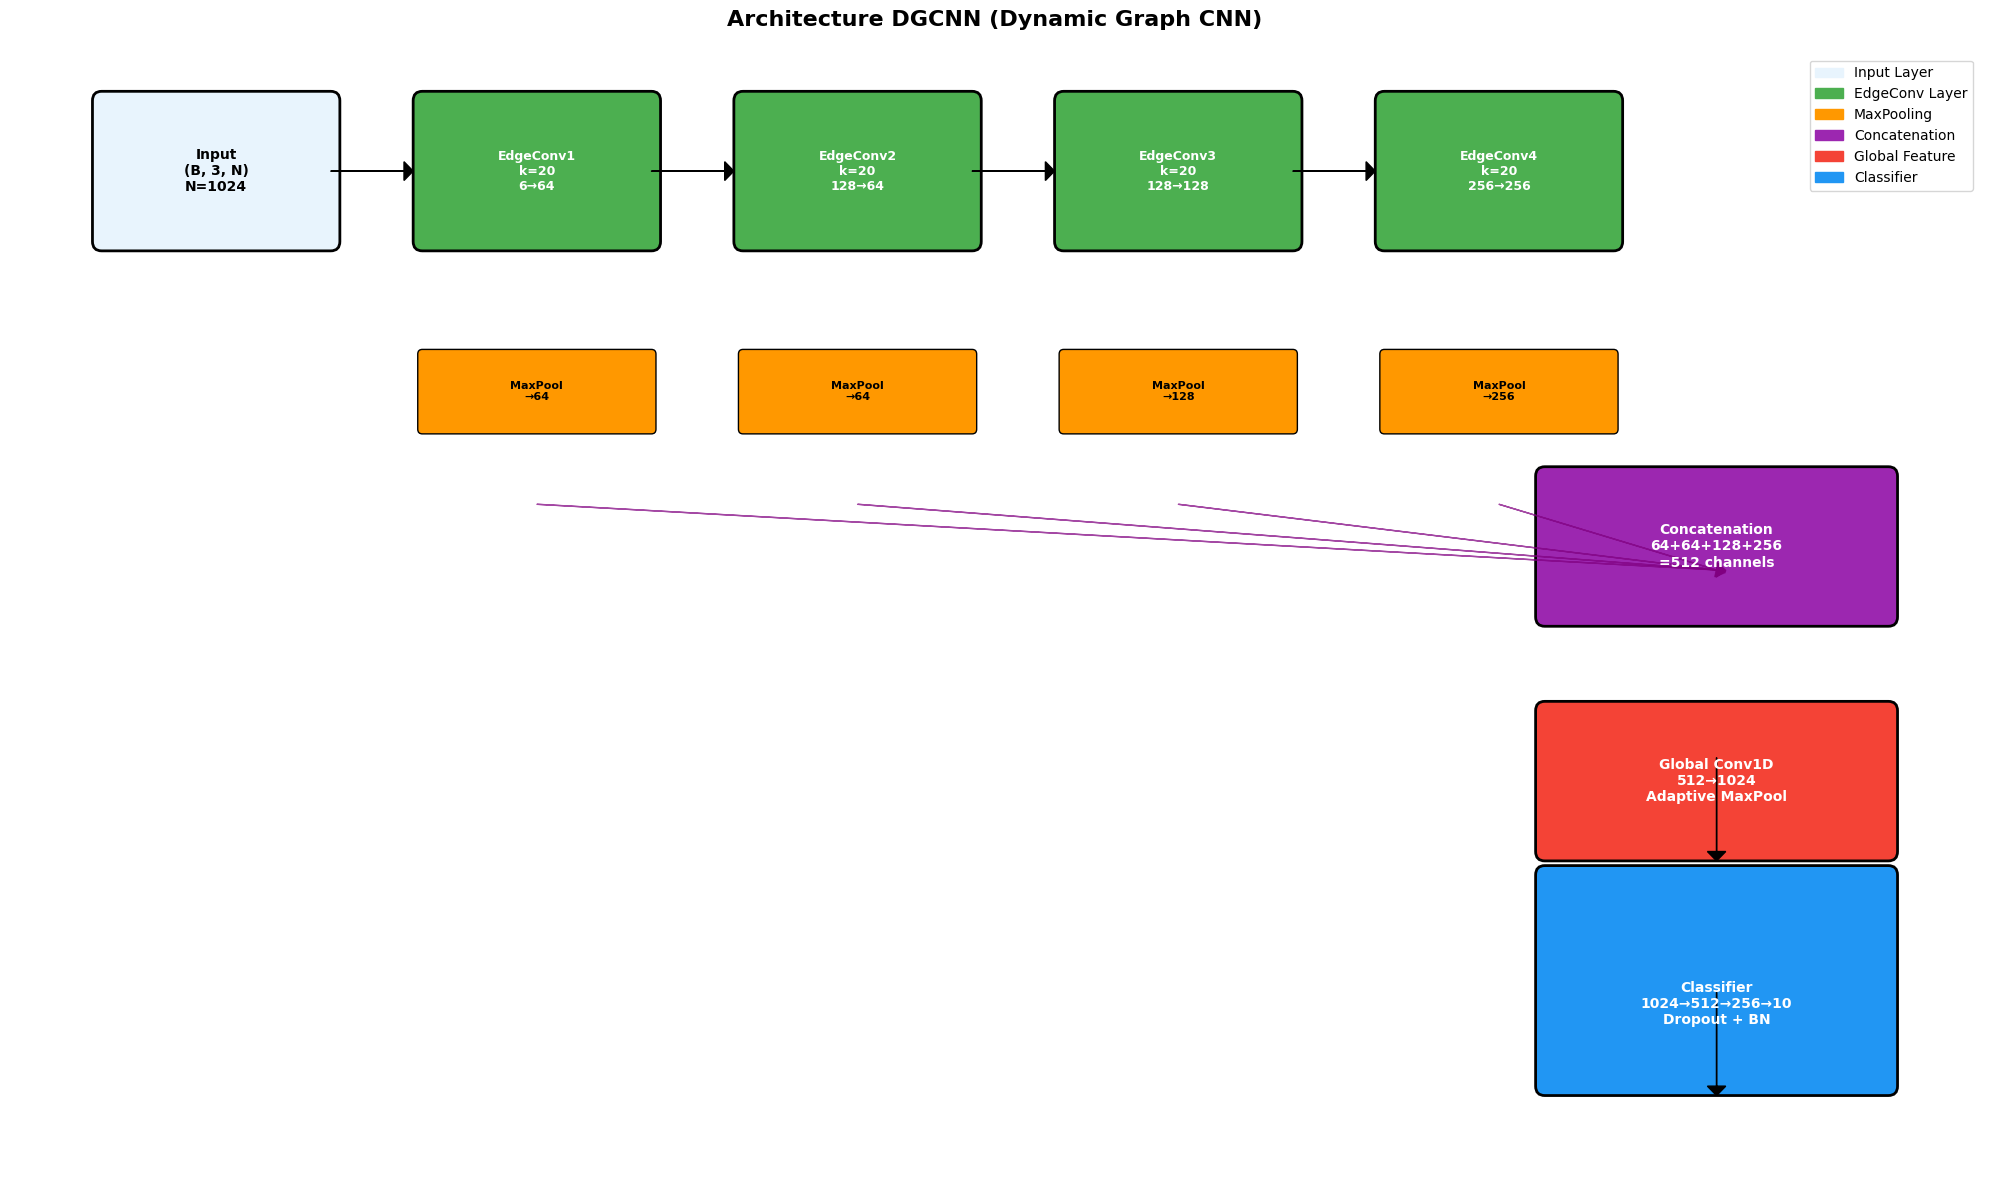

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import numpy as np

def visualize_dgcnn_architecture():
    """Visualise l'architecture du modèle DGCNN"""
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))

    # Configuration des couleurs
    colors = {
        'input': '#E8F4FD',
        'edgeconv': '#4CAF50',
        'maxpool': '#FF9800',
        'concat': '#9C27B0',
        'global': '#F44336',
        'classifier': '#2196F3'
    }

    # Positions des blocs
    y_base = 8
    block_height = 1.5
    block_width = 2.5
    spacing = 3.5

    # Input
    input_box = FancyBboxPatch((0, y_base), block_width, block_height,
                               boxstyle="round,pad=0.1",
                               facecolor=colors['input'],
                               edgecolor='black', linewidth=2)
    ax.add_patch(input_box)
    ax.text(block_width/2, y_base + block_height/2, 'Input\n(B, 3, N)\nN=1024',
            ha='center', va='center', fontsize=10, fontweight='bold')

    # EdgeConv blocks
    edgeconv_info = [
        ('EdgeConv1\nk=20\n6→64', 64),
        ('EdgeConv2\nk=20\n128→64', 64),
        ('EdgeConv3\nk=20\n128→128', 128),
        ('EdgeConv4\nk=20\n256→256', 256)
    ]

    x_positions = []
    for i, (label, channels) in enumerate(edgeconv_info):
        x_pos = (i + 1) * spacing
        x_positions.append(x_pos)

        # EdgeConv block
        edgeconv_box = FancyBboxPatch((x_pos, y_base), block_width, block_height,
                                      boxstyle="round,pad=0.1",
                                      facecolor=colors['edgeconv'],
                                      edgecolor='black', linewidth=2)
        ax.add_patch(edgeconv_box)
        ax.text(x_pos + block_width/2, y_base + block_height/2, label,
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

        # MaxPool
        maxpool_box = FancyBboxPatch((x_pos, y_base - 2), block_width, 0.8,
                                     boxstyle="round,pad=0.05",
                                     facecolor=colors['maxpool'],
                                     edgecolor='black', linewidth=1)
        ax.add_patch(maxpool_box)
        ax.text(x_pos + block_width/2, y_base - 1.6, f'MaxPool\n→{channels}',
                ha='center', va='center', fontsize=8, fontweight='bold')

        # Flèches
        if i > 0:
            ax.arrow(x_positions[i-1] + block_width, y_base + block_height/2,
                    spacing - block_width - 0.2, 0,
                    head_width=0.2, head_length=0.1, fc='black', ec='black')
        else:
            ax.arrow(block_width, y_base + block_height/2,
                    spacing - block_width - 0.2, 0,
                    head_width=0.2, head_length=0.1, fc='black', ec='black')

    # Concatenation
    concat_x = len(edgeconv_info) * spacing + spacing/2
    concat_box = FancyBboxPatch((concat_x, y_base - 4), block_width * 1.5, block_height,
                                boxstyle="round,pad=0.1",
                                facecolor=colors['concat'],
                                edgecolor='black', linewidth=2)
    ax.add_patch(concat_box)
    ax.text(concat_x + block_width*0.75, y_base - 3.25, 'Concatenation\n64+64+128+256\n=512 channels',
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    # Flèches vers concatenation
    for i, x_pos in enumerate(x_positions):
        ax.arrow(x_pos + block_width/2, y_base - 2.8,
                concat_x + block_width*0.75 - (x_pos + block_width/2), -0.7,
                head_width=0.15, head_length=0.1, fc='purple', ec='purple', alpha=0.7)

    # Global Conv1D
    global_x = concat_x
    global_box = FancyBboxPatch((global_x, y_base - 6.5), block_width * 1.5, block_height,
                                boxstyle="round,pad=0.1",
                                facecolor=colors['global'],
                                edgecolor='black', linewidth=2)
    ax.add_patch(global_box)
    ax.text(global_x + block_width*0.75, y_base - 5.75, 'Global Conv1D\n512→1024\nAdaptive MaxPool',
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    # Classifier
    classifier_x = global_x
    classifier_box = FancyBboxPatch((classifier_x, y_base - 9), block_width * 1.5, block_height * 1.5,
                                    boxstyle="round,pad=0.1",
                                    facecolor=colors['classifier'],
                                    edgecolor='black', linewidth=2)
    ax.add_patch(classifier_box)
    ax.text(classifier_x + block_width*0.75, y_base - 8.125, 'Classifier\n1024→512→256→10\nDropout + BN',
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    # Flèches verticales
    ax.arrow(concat_x + block_width*0.75, y_base - 4 - block_height,
            0, -1,
            head_width=0.2, head_length=0.1, fc='black', ec='black')

    ax.arrow(global_x + block_width*0.75, y_base - 6.5 - block_height,
            0, -1,
            head_width=0.2, head_length=0.1, fc='black', ec='black')

    # Titre et labels
    ax.set_title('Architecture DGCNN (Dynamic Graph CNN)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlim(-1, concat_x + block_width * 1.5 + 1)
    ax.set_ylim(y_base - 10, y_base + 2)
    ax.axis('off')

    # Légende
    legend_elements = [
        patches.Patch(color=colors['input'], label='Input Layer'),
        patches.Patch(color=colors['edgeconv'], label='EdgeConv Layer'),
        patches.Patch(color=colors['maxpool'], label='MaxPooling'),
        patches.Patch(color=colors['concat'], label='Concatenation'),
        patches.Patch(color=colors['global'], label='Global Feature'),
        patches.Patch(color=colors['classifier'], label='Classifier')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

# Afficher l'architecture
visualize_dgcnn_architecture()

***Analyse de la complexité du modèle***

Analyse de la complexité du modèle...


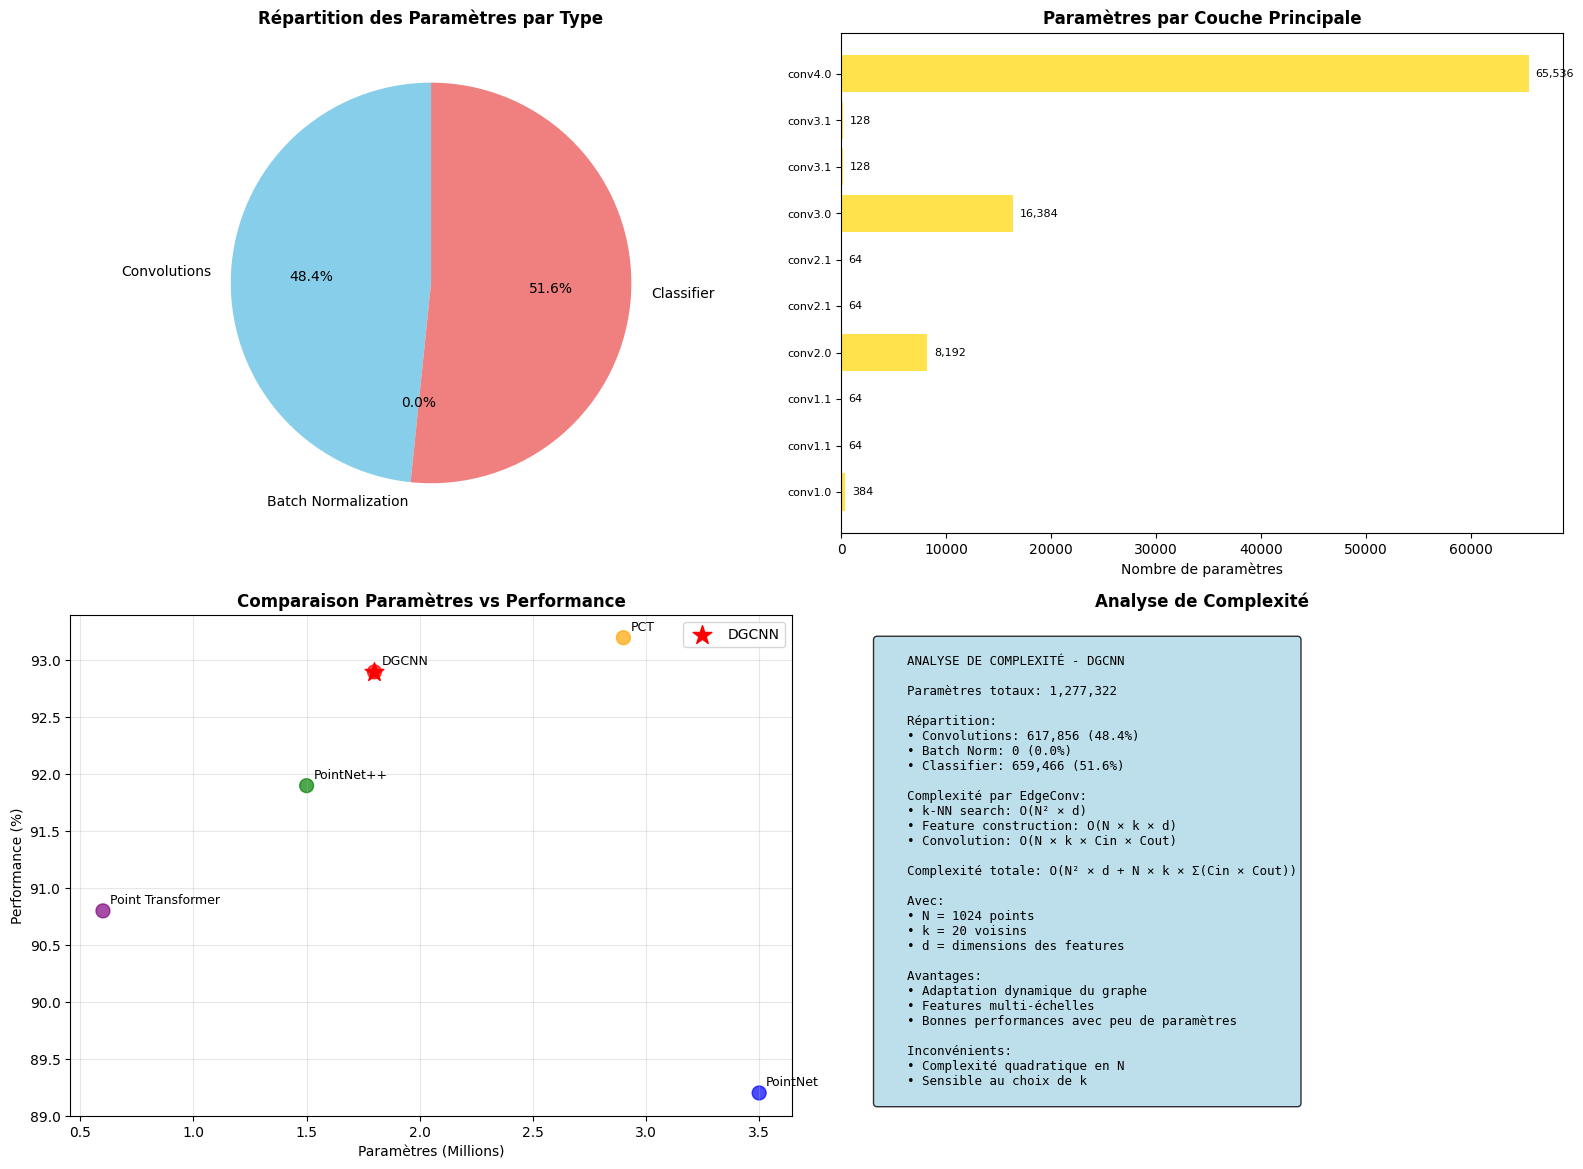

In [17]:
def model_complexity_analysis(model):
    """Analyse la complexité du modèle DGCNN"""

    # Calculer les paramètres par couche
    layer_params = []
    layer_names = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            layer_names.append(name)
            layer_params.append(param.numel())

    # Grouper par type de couche
    conv_params = sum([p for n, p in zip(layer_names, layer_params) if 'conv' in n])
    bn_params = sum([p for n, p in zip(layer_names, layer_params) if 'bn' in n or 'BatchNorm' in n])
    classifier_params = sum([p for n, p in zip(layer_names, layer_params) if 'classifier' in n])

    # Créer les visualisations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Répartition des paramètres par type
    param_types = ['Convolutions', 'Batch Normalization', 'Classifier']
    param_counts = [conv_params, bn_params, classifier_params]
    colors = ['skyblue', 'lightgreen', 'lightcoral']

    wedges, texts, autotexts = axes[0, 0].pie(param_counts, labels=param_types, colors=colors,
                                              autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Répartition des Paramètres par Type', fontweight='bold')

    # 2. Paramètres par couche individuelle
    # Sélectionner les couches principales
    main_layers = [(n, p) for n, p in zip(layer_names, layer_params)
                   if any(key in n for key in ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'classifier'])]

    if len(main_layers) > 10:  # Limiter l'affichage
        main_layers = main_layers[:10]

    layer_names_short = [n.split('.')[0] + '.' + n.split('.')[1] if '.' in n else n
                        for n, _ in main_layers]
    layer_param_counts = [p for _, p in main_layers]

    axes[0, 1].barh(range(len(layer_names_short)), layer_param_counts, color='gold', alpha=0.7)
    axes[0, 1].set_yticks(range(len(layer_names_short)))
    axes[0, 1].set_yticklabels(layer_names_short, fontsize=8)
    axes[0, 1].set_xlabel('Nombre de paramètres')
    axes[0, 1].set_title('Paramètres par Couche Principale', fontweight='bold')

    # Ajouter les valeurs
    for i, v in enumerate(layer_param_counts):
        axes[0, 1].text(v + max(layer_param_counts)*0.01, i, f'{v:,}',
                       va='center', fontsize=8)

    # 3. Comparaison avec d'autres architectures
    architectures = ['DGCNN', 'PointNet', 'PointNet++', 'PCT', 'Point Transformer']
    param_millions = [1.8, 3.5, 1.5, 2.9, 0.6]  # Valeurs approximatives
    performance = [92.9, 89.2, 91.9, 93.2, 90.8]  # Accuracies approximatives sur ModelNet40

    scatter = axes[1, 0].scatter(param_millions, performance,
                                c=['red', 'blue', 'green', 'orange', 'purple'],
                                s=100, alpha=0.7)

    # Annoter les points
    for i, arch in enumerate(architectures):
        axes[1, 0].annotate(arch, (param_millions[i], performance[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=9)

    axes[1, 0].set_xlabel('Paramètres (Millions)')
    axes[1, 0].set_ylabel('Performance (%)')
    axes[1, 0].set_title('Comparaison Paramètres vs Performance', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Mettre en évidence DGCNN
    dgcnn_idx = architectures.index('DGCNN')
    axes[1, 0].scatter(param_millions[dgcnn_idx], performance[dgcnn_idx],
                      c='red', s=200, marker='*', label='DGCNN')
    axes[1, 0].legend()

    # 4. Complexité computationnelle
    complexity_text = f"""
    ANALYSE DE COMPLEXITÉ - DGCNN

    Paramètres totaux: {sum(layer_params):,}

    Répartition:
    • Convolutions: {conv_params:,} ({100*conv_params/sum(layer_params):.1f}%)
    • Batch Norm: {bn_params:,} ({100*bn_params/sum(layer_params):.1f}%)
    • Classifier: {classifier_params:,} ({100*classifier_params/sum(layer_params):.1f}%)

    Complexité par EdgeConv:
    • k-NN search: O(N² × d)
    • Feature construction: O(N × k × d)
    • Convolution: O(N × k × Cin × Cout)

    Complexité totale: O(N² × d + N × k × Σ(Cin × Cout))

    Avec:
    • N = {NUM_POINTS} points
    • k = 20 voisins
    • d = dimensions des features

    Avantages:
    • Adaptation dynamique du graphe
    • Features multi-échelles
    • Bonnes performances avec peu de paramètres

    Inconvénients:
    • Complexité quadratique en N
    • Sensible au choix de k
    """

    axes[1, 1].text(0.05, 0.95, complexity_text, transform=axes[1, 1].transAxes,
                    fontsize=9, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Analyse de Complexité', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return {
        'total_params': sum(layer_params),
        'conv_params': conv_params,
        'bn_params': bn_params,
        'classifier_params': classifier_params
    }

# Analyser la complexité du modèle
print("Analyse de la complexité du modèle...")
complexity_stats = model_complexity_analysis(model)

# **CELLULE 6: Préparation des données**

In [6]:
# Paramètres
NUM_POINTS = 1024
BATCH_SIZE = 16
NUM_CLASSES = 10

# Créer les datasets
train_dataset = ModelNet10Dataset('ModelNet10', split='train', num_points=NUM_POINTS)
test_dataset = ModelNet10Dataset('ModelNet10', split='test', num_points=NUM_POINTS)

# Créer les dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Nombre d'échantillons d'entraînement: {len(train_dataset)}")
print(f"Nombre d'échantillons de test: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Dataset train: 3991 fichiers chargés
Dataset test: 908 fichiers chargés
Nombre d'échantillons d'entraînement: 3991
Nombre d'échantillons de test: 908
Classes: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']


# **Initialisation du modèle**

In [7]:
# Créer le modèle
model = DGCNN(num_classes=NUM_CLASSES, k=20, dropout=0.5).to(device)

# Optimizer et loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
criterion = nn.CrossEntropyLoss()

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Paramètres totaux: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")


Paramètres totaux: 1,277,322
Paramètres entraînables: 1,277,322


# **Fonctions d'entraînement et de test**

In [8]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Entraîne le modèle pour une époque"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Entraînement')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.squeeze().to(device)

        # Transposer pour DGCNN (batch_size, 3, num_points)
        data = data.transpose(2, 1)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        # Mise à jour de la barre de progression
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    return total_loss / len(train_loader), 100. * correct / total

def test_epoch(model, test_loader, criterion, device):
    """Teste le modèle"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Test')
        for data, target in pbar:
            data, target = data.to(device), target.squeeze().to(device)

            # Transposer pour DGCNN
            data = data.transpose(2, 1)

            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    return total_loss / len(test_loader), 100. * correct / total, all_preds, all_targets


# **Boucle d'entraînement principale**

In [18]:
# Paramètres d'entraînement
NUM_EPOCHS = 50
best_acc = 0
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("Début de l'entraînement...")
for epoch in range(NUM_EPOCHS):
    print(f'\nÉpoque {epoch+1}/{NUM_EPOCHS}')
    print('-' * 50)

    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

    # Test
    test_loss, test_acc, test_preds, test_targets = test_epoch(model, test_loader, criterion, device)

    # Scheduler
    scheduler.step()

    # Sauvegarde du meilleur modèle
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_dgcnn_model.pth')
        print(f'Nouveau meilleur modèle sauvegardé! Précision: {best_acc:.2f}%')

    # Stockage des métriques
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

print(f'\nEntraînement terminé! Meilleure précision: {best_acc:.2f}%')


Début de l'entraînement...

Époque 1/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.79it/s, Loss=0.3405, Acc=64.21%]


Nouveau meilleur modèle sauvegardé! Précision: 64.21%
Train Loss: 0.9764, Train Acc: 67.98%
Test Loss: 1.0200, Test Acc: 64.21%
Learning Rate: 0.001000

Époque 2/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.82it/s, Loss=0.2372, Acc=75.66%]


Nouveau meilleur modèle sauvegardé! Précision: 75.66%
Train Loss: 0.5751, Train Acc: 80.73%
Test Loss: 0.6761, Test Acc: 75.66%
Learning Rate: 0.001000

Époque 3/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.95it/s, Loss=0.1632, Acc=78.30%]


Nouveau meilleur modèle sauvegardé! Précision: 78.30%
Train Loss: 0.5163, Train Acc: 82.46%
Test Loss: 0.6004, Test Acc: 78.30%
Learning Rate: 0.001000

Époque 4/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.91it/s, Loss=0.5329, Acc=77.64%]


Train Loss: 0.4554, Train Acc: 84.87%
Test Loss: 0.6070, Test Acc: 77.64%
Learning Rate: 0.001000

Époque 5/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.72it/s, Loss=0.3949, Acc=80.51%]


Nouveau meilleur modèle sauvegardé! Précision: 80.51%
Train Loss: 0.4183, Train Acc: 85.37%
Test Loss: 0.5537, Test Acc: 80.51%
Learning Rate: 0.001000

Époque 6/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.74it/s, Loss=0.1450, Acc=80.40%]


Train Loss: 0.4072, Train Acc: 86.19%
Test Loss: 0.5312, Test Acc: 80.40%
Learning Rate: 0.001000

Époque 7/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:21<00:00,  2.70it/s, Loss=0.3244, Acc=81.17%]


Nouveau meilleur modèle sauvegardé! Précision: 81.17%
Train Loss: 0.3925, Train Acc: 86.42%
Test Loss: 0.5341, Test Acc: 81.17%
Learning Rate: 0.001000

Époque 8/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.88it/s, Loss=0.1808, Acc=82.38%]


Nouveau meilleur modèle sauvegardé! Précision: 82.38%
Train Loss: 0.3444, Train Acc: 88.15%
Test Loss: 0.5026, Test Acc: 82.38%
Learning Rate: 0.001000

Époque 9/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.97it/s, Loss=0.3698, Acc=80.84%]


Train Loss: 0.3594, Train Acc: 88.15%
Test Loss: 0.5260, Test Acc: 80.84%
Learning Rate: 0.001000

Époque 10/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.90it/s, Loss=0.4570, Acc=83.15%]


Nouveau meilleur modèle sauvegardé! Précision: 83.15%
Train Loss: 0.3217, Train Acc: 89.23%
Test Loss: 0.4610, Test Acc: 83.15%
Learning Rate: 0.001000

Époque 11/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.99it/s, Loss=0.4061, Acc=84.36%]


Nouveau meilleur modèle sauvegardé! Précision: 84.36%
Train Loss: 0.3153, Train Acc: 88.98%
Test Loss: 0.4528, Test Acc: 84.36%
Learning Rate: 0.001000

Époque 12/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.74it/s, Loss=0.2082, Acc=84.69%]


Nouveau meilleur modèle sauvegardé! Précision: 84.69%
Train Loss: 0.3072, Train Acc: 89.60%
Test Loss: 0.4348, Test Acc: 84.69%
Learning Rate: 0.001000

Époque 13/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.75it/s, Loss=0.5699, Acc=86.45%]


Nouveau meilleur modèle sauvegardé! Précision: 86.45%
Train Loss: 0.3110, Train Acc: 89.20%
Test Loss: 0.4309, Test Acc: 86.45%
Learning Rate: 0.001000

Époque 14/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.75it/s, Loss=0.4185, Acc=84.36%]


Train Loss: 0.2815, Train Acc: 90.45%
Test Loss: 0.4843, Test Acc: 84.36%
Learning Rate: 0.001000

Époque 15/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.76it/s, Loss=0.1878, Acc=85.46%]


Train Loss: 0.2900, Train Acc: 89.45%
Test Loss: 0.4238, Test Acc: 85.46%
Learning Rate: 0.001000

Époque 16/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.84it/s, Loss=1.0035, Acc=83.15%]


Train Loss: 0.2963, Train Acc: 89.68%
Test Loss: 0.5013, Test Acc: 83.15%
Learning Rate: 0.001000

Époque 17/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.88it/s, Loss=0.7026, Acc=85.02%]


Train Loss: 0.2761, Train Acc: 90.38%
Test Loss: 0.4211, Test Acc: 85.02%
Learning Rate: 0.001000

Époque 18/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.84it/s, Loss=0.9995, Acc=83.26%]


Train Loss: 0.2669, Train Acc: 91.16%
Test Loss: 0.5208, Test Acc: 83.26%
Learning Rate: 0.001000

Époque 19/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.73it/s, Loss=0.4437, Acc=83.70%]


Train Loss: 0.2539, Train Acc: 91.31%
Test Loss: 0.4977, Test Acc: 83.70%
Learning Rate: 0.001000

Époque 20/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.74it/s, Loss=0.3924, Acc=85.68%]


Train Loss: 0.2472, Train Acc: 91.58%
Test Loss: 0.3934, Test Acc: 85.68%
Learning Rate: 0.000700

Époque 21/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.91it/s, Loss=0.2970, Acc=86.23%]


Train Loss: 0.2065, Train Acc: 93.18%
Test Loss: 0.4463, Test Acc: 86.23%
Learning Rate: 0.000700

Époque 22/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.90it/s, Loss=0.8280, Acc=84.58%]


Train Loss: 0.2027, Train Acc: 93.39%
Test Loss: 0.4761, Test Acc: 84.58%
Learning Rate: 0.000700

Époque 23/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.94it/s, Loss=0.5282, Acc=85.24%]


Train Loss: 0.1967, Train Acc: 93.61%
Test Loss: 0.4618, Test Acc: 85.24%
Learning Rate: 0.000700

Époque 24/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.79it/s, Loss=0.4015, Acc=86.12%]


Train Loss: 0.2012, Train Acc: 92.91%
Test Loss: 0.4476, Test Acc: 86.12%
Learning Rate: 0.000700

Époque 25/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.73it/s, Loss=0.2488, Acc=83.15%]


Train Loss: 0.1971, Train Acc: 93.34%
Test Loss: 0.5033, Test Acc: 83.15%
Learning Rate: 0.000700

Époque 26/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.76it/s, Loss=0.5428, Acc=86.23%]


Train Loss: 0.1989, Train Acc: 93.18%
Test Loss: 0.4170, Test Acc: 86.23%
Learning Rate: 0.000700

Époque 27/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.77it/s, Loss=0.6832, Acc=87.33%]


Nouveau meilleur modèle sauvegardé! Précision: 87.33%
Train Loss: 0.1693, Train Acc: 94.16%
Test Loss: 0.4321, Test Acc: 87.33%
Learning Rate: 0.000700

Époque 28/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.91it/s, Loss=0.6570, Acc=86.45%]


Train Loss: 0.1802, Train Acc: 93.79%
Test Loss: 0.4705, Test Acc: 86.45%
Learning Rate: 0.000700

Époque 29/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.85it/s, Loss=1.0527, Acc=85.24%]


Train Loss: 0.1903, Train Acc: 93.61%
Test Loss: 0.4740, Test Acc: 85.24%
Learning Rate: 0.000700

Époque 30/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.92it/s, Loss=0.6041, Acc=84.58%]


Train Loss: 0.1899, Train Acc: 93.28%
Test Loss: 0.4925, Test Acc: 84.58%
Learning Rate: 0.000700

Époque 31/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.91it/s, Loss=0.6408, Acc=87.22%]


Train Loss: 0.1763, Train Acc: 94.11%
Test Loss: 0.4080, Test Acc: 87.22%
Learning Rate: 0.000700

Époque 32/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:21<00:00,  2.71it/s, Loss=0.8387, Acc=84.91%]


Train Loss: 0.1636, Train Acc: 94.34%
Test Loss: 0.4970, Test Acc: 84.91%
Learning Rate: 0.000700

Époque 33/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.75it/s, Loss=0.5294, Acc=87.00%]


Train Loss: 0.1789, Train Acc: 93.84%
Test Loss: 0.4477, Test Acc: 87.00%
Learning Rate: 0.000700

Époque 34/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.87it/s, Loss=0.5139, Acc=86.23%]


Train Loss: 0.1714, Train Acc: 93.96%
Test Loss: 0.4188, Test Acc: 86.23%
Learning Rate: 0.000700

Époque 35/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.94it/s, Loss=0.9307, Acc=86.89%]


Train Loss: 0.1584, Train Acc: 94.26%
Test Loss: 0.4086, Test Acc: 86.89%
Learning Rate: 0.000700

Époque 36/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.93it/s, Loss=0.8156, Acc=84.91%]


Train Loss: 0.1616, Train Acc: 94.29%
Test Loss: 0.4431, Test Acc: 84.91%
Learning Rate: 0.000700

Époque 37/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.89it/s, Loss=0.9333, Acc=86.45%]


Train Loss: 0.1642, Train Acc: 94.36%
Test Loss: 0.4418, Test Acc: 86.45%
Learning Rate: 0.000700

Époque 38/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.88it/s, Loss=0.4733, Acc=85.79%]


Train Loss: 0.1632, Train Acc: 94.71%
Test Loss: 0.4399, Test Acc: 85.79%
Learning Rate: 0.000700

Époque 39/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.75it/s, Loss=0.6184, Acc=87.78%]


Nouveau meilleur modèle sauvegardé! Précision: 87.78%
Train Loss: 0.1740, Train Acc: 94.24%
Test Loss: 0.3956, Test Acc: 87.78%
Learning Rate: 0.000700

Époque 40/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:21<00:00,  2.65it/s, Loss=1.0163, Acc=87.67%]


Train Loss: 0.1410, Train Acc: 95.44%
Test Loss: 0.4762, Test Acc: 87.67%
Learning Rate: 0.000490

Époque 41/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.72it/s, Loss=0.5825, Acc=88.11%]


Nouveau meilleur modèle sauvegardé! Précision: 88.11%
Train Loss: 0.1336, Train Acc: 95.39%
Test Loss: 0.3884, Test Acc: 88.11%
Learning Rate: 0.000490

Époque 42/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.89it/s, Loss=0.6040, Acc=87.22%]


Train Loss: 0.1214, Train Acc: 95.94%
Test Loss: 0.4160, Test Acc: 87.22%
Learning Rate: 0.000490

Époque 43/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:24<00:00,  2.30it/s, Loss=0.5016, Acc=87.33%]


Train Loss: 0.1152, Train Acc: 96.07%
Test Loss: 0.3837, Test Acc: 87.33%
Learning Rate: 0.000490

Époque 44/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.73it/s, Loss=0.8363, Acc=86.34%]


Train Loss: 0.1166, Train Acc: 96.32%
Test Loss: 0.4250, Test Acc: 86.34%
Learning Rate: 0.000490

Époque 45/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.88it/s, Loss=0.7789, Acc=88.11%]


Train Loss: 0.1017, Train Acc: 96.59%
Test Loss: 0.4145, Test Acc: 88.11%
Learning Rate: 0.000490

Époque 46/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.91it/s, Loss=0.7337, Acc=87.11%]


Train Loss: 0.1130, Train Acc: 96.04%
Test Loss: 0.4290, Test Acc: 87.11%
Learning Rate: 0.000490

Époque 47/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.88it/s, Loss=0.8604, Acc=85.68%]


Train Loss: 0.1082, Train Acc: 95.99%
Test Loss: 0.4493, Test Acc: 85.68%
Learning Rate: 0.000490

Époque 48/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:19<00:00,  2.88it/s, Loss=0.9562, Acc=86.56%]


Train Loss: 0.1031, Train Acc: 96.44%
Test Loss: 0.4356, Test Acc: 86.56%
Learning Rate: 0.000490

Époque 49/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.83it/s, Loss=0.7878, Acc=87.56%]


Train Loss: 0.1106, Train Acc: 96.49%
Test Loss: 0.4385, Test Acc: 87.56%
Learning Rate: 0.000490

Époque 50/50
--------------------------------------------------


Test: 100%|██████████| 57/57 [00:20<00:00,  2.74it/s, Loss=0.7036, Acc=86.45%]

Train Loss: 0.1213, Train Acc: 95.92%
Test Loss: 0.4385, Test Acc: 86.45%
Learning Rate: 0.000490

Entraînement terminé! Meilleure précision: 88.11%


# **Visualisation des résultats**

Test: 100%|██████████| 57/57 [00:19<00:00,  2.93it/s, Loss=0.5959, Acc=87.56%]


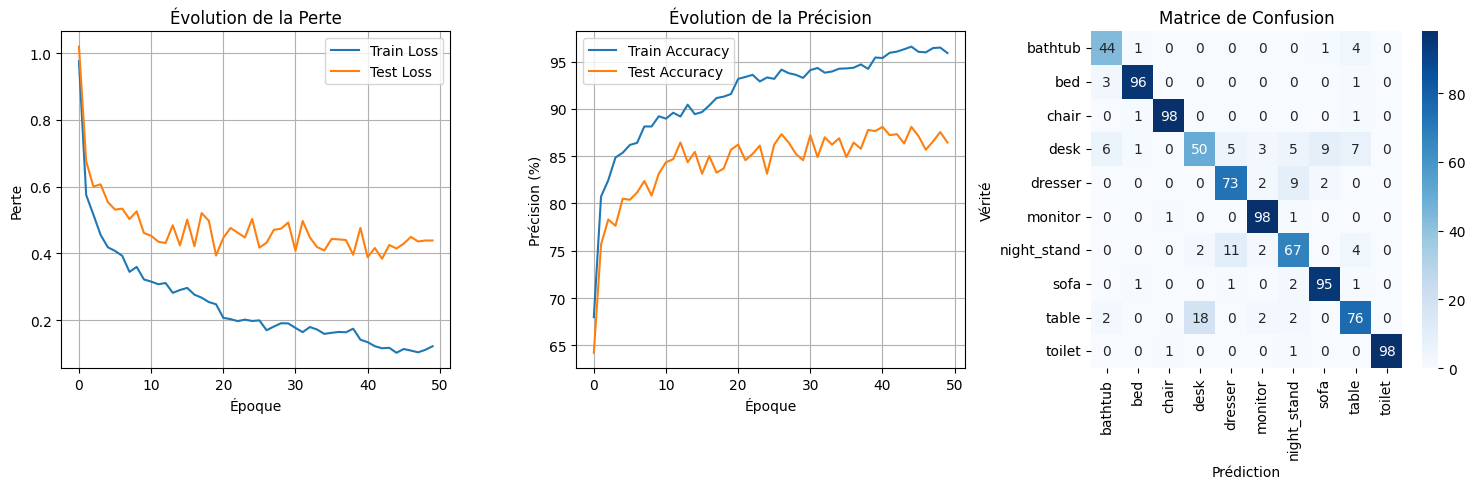


Rapport de classification:
              precision    recall  f1-score   support

     bathtub       0.80      0.88      0.84        50
         bed       0.96      0.96      0.96       100
       chair       0.98      0.98      0.98       100
        desk       0.71      0.58      0.64        86
     dresser       0.81      0.85      0.83        86
     monitor       0.92      0.98      0.95       100
 night_stand       0.77      0.78      0.77        86
        sofa       0.89      0.95      0.92       100
       table       0.81      0.76      0.78       100
      toilet       1.00      0.98      0.99       100

    accuracy                           0.88       908
   macro avg       0.86      0.87      0.87       908
weighted avg       0.87      0.88      0.87       908



In [19]:
# Charger le meilleur modèle
model.load_state_dict(torch.load('best_dgcnn_model.pth'))

# Évaluation finale
test_loss, test_acc, final_preds, final_targets = test_epoch(model, test_loader, criterion, device)

# Graphiques de perte et précision
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Évolution de la Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Évolution de la Précision')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.legend()
plt.grid(True)

# Matrice de confusion
plt.subplot(1, 3, 3)
cm = confusion_matrix(final_targets, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')

plt.tight_layout()
plt.show()

# Rapport de classification
print("\nRapport de classification:")
print(classification_report(final_targets, final_preds,
                          target_names=train_dataset.classes))

# **Fonction de prédiction sur nouvelles données**

# **Test avec quelques échantillons**

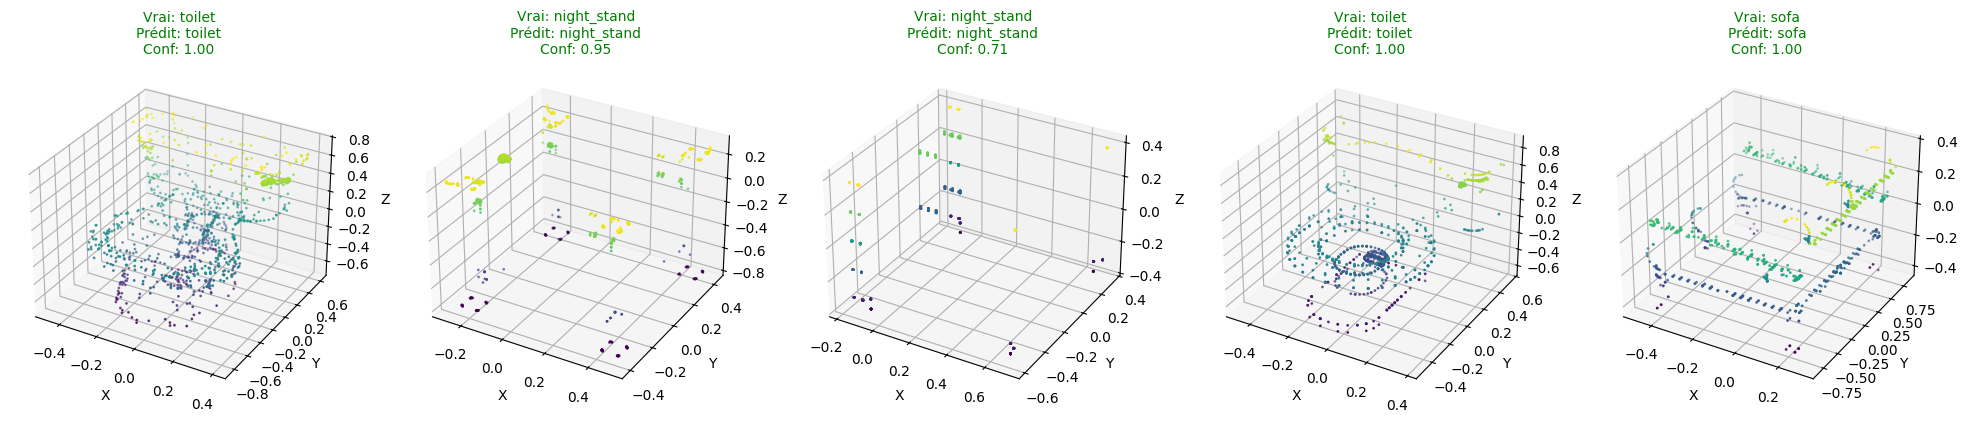

Visualisation terminée!
Précision finale du modèle: 88.11%


In [22]:
# Tester avec quelques échantillons du dataset de test
model.eval()
num_samples_to_show = 5

plt.figure(figsize=(20, 4))

for i in range(num_samples_to_show):
    # Prendre un échantillon aléatoire
    idx = np.random.randint(0, len(test_dataset))
    points, true_label = test_dataset[idx]
    true_class = train_dataset.classes[true_label.item()]

    # Prédiction
    pred_class_idx, confidence, pred_class = predict_single_object(
        model, points, device, train_dataset.classes
    )

    # Visualisation 3D
    ax = plt.subplot(1, num_samples_to_show, i+1, projection='3d')
    points_np = points.numpy()
    ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2],
               c=points_np[:, 2], cmap='viridis', s=1)

    # Titre avec prédiction
    color = 'green' if pred_class == true_class else 'red'
    ax.set_title(f'Vrai: {true_class}\nPrédit: {pred_class}\nConf: {confidence:.2f}',
                 color=color, fontsize=10)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

print("Visualisation terminée!")
print(f"Précision finale du modèle: {best_acc:.2f}%")

***Prédictions et analyse d'erreurs***

Analyse des prédictions et erreurs...
Visualisation des bonnes prédictions...
Visualisation des erreurs de prédiction...


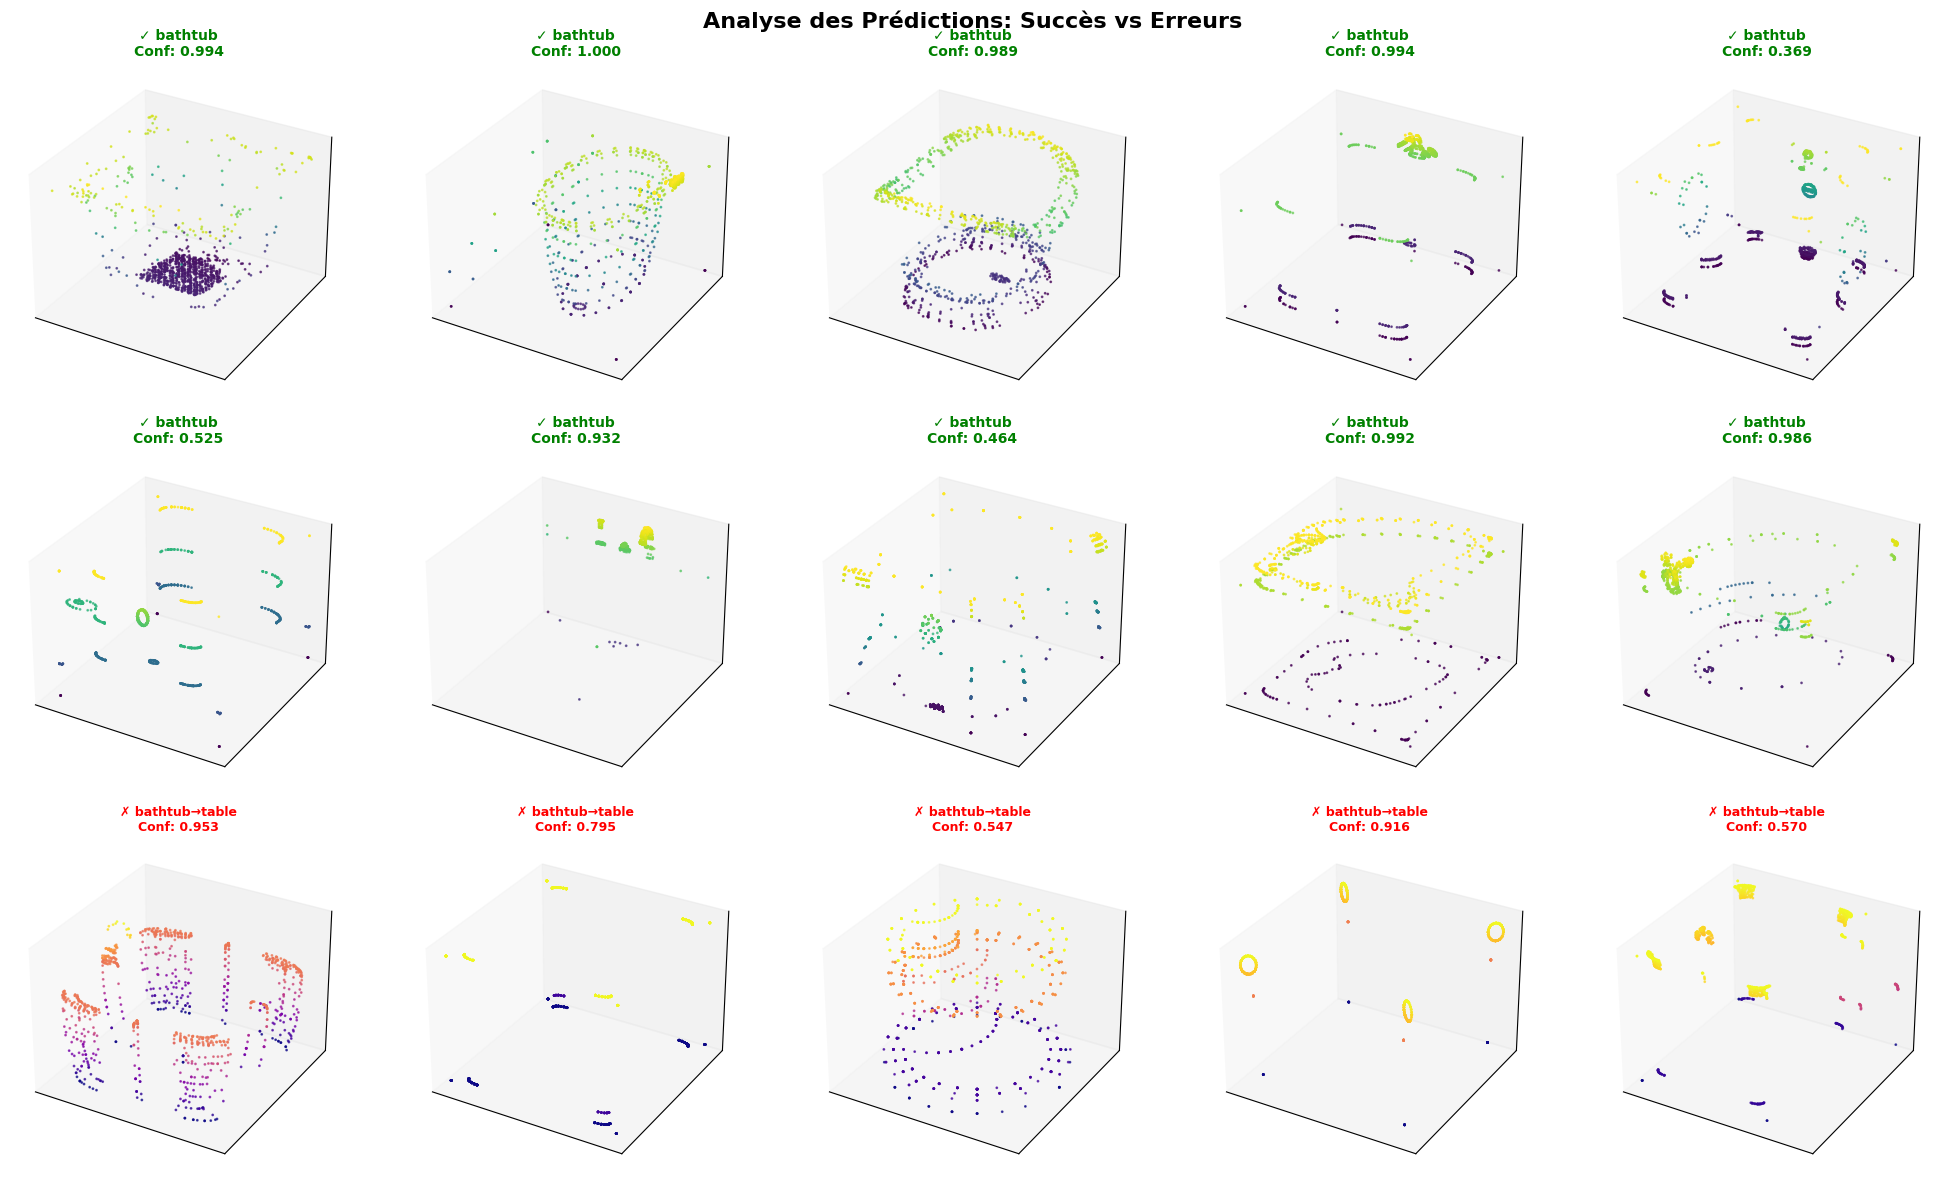


Analyse des erreurs les plus fréquentes:
--------------------------------------------------
bathtub → table: 5 erreurs
Échantillons analysés: 35 corrects, 5 incorrects

TOUTES LES VISUALISATIONS AVANCÉES TERMINÉES!
Visualisations créées:
1. Architecture DGCNN détaillée
2. Fichiers OFF originaux
3. Comparaison avant/après prétraitement
4. Distribution complète du dataset
5. Analyse statistique des nuages de points
6. Visualisation 3D multi-angles
7. Concepts EdgeConv et construction de graphe
8. Analyse de complexité du modèle


In [23]:
def analyze_predictions_and_errors(model, test_loader, dataset, device, num_samples=20):
    """Analyse les prédictions et les erreurs du modèle"""

    model.eval()
    correct_predictions = []
    incorrect_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.squeeze().to(device)
            data = data.transpose(2, 1)

            output = model(data)
            pred = output.argmax(dim=1)

            # Calculer les probabilités
            probs = F.softmax(output, dim=1)

            for i in range(len(pred)):
                sample_info = {
                    'true_class': target[i].item(),
                    'pred_class': pred[i].item(),
                    'confidence': probs[i, pred[i]].item(),
                    'probabilities': probs[i].cpu().numpy(),
                    'points': data[i].transpose(1, 0).cpu().numpy()
                }

                if pred[i] == target[i]:
                    correct_predictions.append(sample_info)
                else:
                    incorrect_predictions.append(sample_info)

                if len(correct_predictions) + len(incorrect_predictions) >= num_samples * 2:
                    break

            if len(correct_predictions) + len(incorrect_predictions) >= num_samples * 2:
                break

    # Créer les visualisations
    fig = plt.figure(figsize=(20, 16))

    # 1. Bonnes prédictions
    print("Visualisation des bonnes prédictions...")
    for i in range(min(num_samples // 2, len(correct_predictions))):
        sample = correct_predictions[i]
        ax = fig.add_subplot(4, 5, i + 1, projection='3d')

        points = sample['points']
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                  c=points[:, 2], cmap='viridis', s=1, alpha=0.7)

        true_class = dataset.classes[sample['true_class']]
        confidence = sample['confidence']

        ax.set_title(f'✓ {true_class}\nConf: {confidence:.3f}',
                    fontsize=10, fontweight='bold', color='green')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    # 2. Mauvaises prédictions
    print("Visualisation des erreurs de prédiction...")
    for i in range(min(num_samples // 2, len(incorrect_predictions))):
        sample = incorrect_predictions[i]
        ax = fig.add_subplot(4, 5, i + 11, projection='3d')

        points = sample['points']
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                  c=points[:, 2], cmap='plasma', s=1, alpha=0.7)

        true_class = dataset.classes[sample['true_class']]
        pred_class = dataset.classes[sample['pred_class']]
        confidence = sample['confidence']

        ax.set_title(f'✗ {true_class}→{pred_class}\nConf: {confidence:.3f}',
                    fontsize=9, fontweight='bold', color='red')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    plt.suptitle('Analyse des Prédictions: Succès vs Erreurs', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Analyse statistique des erreurs
    if incorrect_predictions:
        error_analysis = {}
        for sample in incorrect_predictions:
            true_class = dataset.classes[sample['true_class']]
            pred_class = dataset.classes[sample['pred_class']]

            if true_class not in error_analysis:
                error_analysis[true_class] = {}
            if pred_class not in error_analysis[true_class]:
                error_analysis[true_class][pred_class] = 0
            error_analysis[true_class][pred_class] += 1

        print("\nAnalyse des erreurs les plus fréquentes:")
        print("-" * 50)
        for true_class, predictions in error_analysis.items():
            most_common = max(predictions.items(), key=lambda x: x[1])
            print(f"{true_class} → {most_common[0]}: {most_common[1]} erreurs")

    return correct_predictions, incorrect_predictions

# Analyser les prédictions (nécessite que le modèle soit entraîné)
print("Analyse des prédictions et erreurs...")
try:
    correct_preds, incorrect_preds = analyze_predictions_and_errors(
        model, test_loader, train_dataset, device, num_samples=20)
    print(f"Échantillons analysés: {len(correct_preds)} corrects, {len(incorrect_preds)} incorrects")
except Exception as e:
    print(f"Erreur lors de l'analyse des prédictions: {e}")
    print("Assurez-vous que le modèle est entraîné avant d'exécuter cette cellule.")

print("\n" + "="*80)
print("TOUTES LES VISUALISATIONS AVANCÉES TERMINÉES!")
print("="*80)
print("Visualisations créées:")
print("1. Architecture DGCNN détaillée")
print("2. Fichiers OFF originaux")
print("3. Comparaison avant/après prétraitement")
print("4. Distribution complète du dataset")
print("5. Analyse statistique des nuages de points")
print("6. Visualisation 3D multi-angles")
print("7. Concepts EdgeConv et construction de graphe")
print("8. Analyse de complexité du modèle")